<a href="https://colab.research.google.com/github/VanHoann/NMF_in_Facial_Recognition/blob/main/NMF_in_Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/VanHoann/NMF_in_Facial_Recognition

Cloning into 'NMF_in_Facial_Recognition'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (686/686), done.
remote: Compressing objects: 100% (630/630), done.
remote: Total 686 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (686/686), 11.71 MiB | 22.79 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [6]:
cd NMF_in_Facial_Recognition

/content/NMF_in_Facial_Recognition


# Non-negative Matrix Factorization (NMF) with Face datasets
**MATH4995: Capstone Project for Data Science, Fall 2022**

TRINH Van Hoan, VUONG Tung Duong

## Introduction

In this notebook, we examine 2 non-negative matrix factorization versions: $L_{2}$-norm and Kullback-Leibler divergence. Our aim is to establish the performance of these different approaches, and their performance and robustness in related tasks in Facial recognition while managing computational complexity, sensitivity to noise and more. 

To execute the code you just need to go through the notebook and executing all cells.  
* ***Load and preprocessing data*** contains the function to load and preprocess the images. In this section, you should add the path to the folder with the datasets, in case you use Google Colab you need to add the datasets to your Drive account and mount your Drive folder into the notebook.
* ***Utils Functions*** contains functions that are used in the implementation of our algorithms. The functions to generate noise are contained in this section as well as the functions to calculate the metrics. 
* ***Non-negative Matrix Factorization*** contains the implementation of our algorithms.
* ***Experiments*** has the experiments we have executed to analyze the performance of the NMF algorithms. 
* ***Appendix*** contains some images generated for the report.

In [2]:
import numpy as np
import os
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from scipy import misc
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import normalize
np.warnings.filterwarnings('ignore')

## 1.- Load and Preprocessing Data

This section contains the function to load and preprocess the data. The function `load_data` is used to load the data and it applies a scale factor for zooming out the images, in this case we use `reduce=3`. 


**Note:** In this section you need to add the path to the folder with the datasets. Additionally, if you use Google Colab you just need to mount your Drive Folder using the lines above.


In [3]:
def load_data(root='', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))
            
            # Preprocessing
            # Normalize to the range 0-1
            img = img  / 255.0

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

The datasets used to conduct the experiments are ORL and Yale face dataset. 

* The Yale face dataset we used contains 165 images of 15 subjects under different poses and illumination conditions. We load the sample images, using $\text{reduce constant}=3$, into vectors with 8586 elements.

* The ORL dataset contains 400 images of 40 distinct subjects. The images were taken varying the lighting, facial expressions and facial details (some subjects wear glasses).  We applied a `reduce constant=3` to load the sample images into vectors with 1100 elements.

In [8]:
# Reading data - You need to add the path to the folder with the datasets here.
X, Y = load_data("data/orl_faces/Training", reduce=3)

As we mentioned before, we can observe that the ORL dataset contains 400 images (360 training and 40 testing) and the images have been loaded into vectors with 1100 elements - `reduce constante = 3`.

In [9]:
print(f"Shape X: {X.shape}")
print(f"Shape Y: {Y.shape}")

Shape X: (1110, 360)
Shape Y: (360,)


## 2.- Utils Functions

In this section, you will find general functions that will be used in the implementation of the NMF algorithms.

In [10]:
def array2img(array, w=28, h=28):
    """
    Function to convert an 1D array image into a 2D matrix
    
    :param array: 1D array which we want to convert into a 2D matrix
    :param w: Width image
    :param h: Height image
    """
    return np.asarray(array).reshape(w, h)

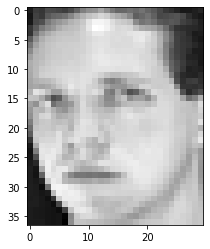

In [ ]:
# Reduce Factor = 3
img_size = [i//3 for i in (92, 112)] # ORL

test_img = array2img(X[:, 0], 
                     h=img_size[0],
                     w=img_size[1])

plt.imshow(test_img, cmap=plt.cm.gray)

### 2.1.- Noise Functions

Functions implemented to generate and add noise to the original images.

#### 2.1.1.- Salt and Pepper Noise

The noise is generated by randomly change some pixel values in the image. The parameters to tune the salt and pepper noise are *p* and *s_vs_p*. The parameter *p* indicates the noise level, for instance `p=0.1` indicates that the `10%` of the pixel values in the image should be modified. On the other hand, the parameter *s_vs_p* controls the ratio between **Salt and Pepper noise**. For example, if `s_vs_p=0.2`, then `20%` of the modified pixel values should be white.

In [ ]:
def salt_pepper_noise(array_img, p=0.4, s_vs_p=0.3):
  """
  Function to apply salt pepper noise to images.

  For example if p = 0:4, then 40% of the pixel values in a image should
  be modified to either 255 (white) or 0 (black). The parameter s_vs_p controls 
  the ratio of being 255 (white) to the number of modified pixel values. 
  For example, if s_vs_p = 0:3, then 30% of the modified pixel values 
  should be 255 (white).

  :param array_img: Image in 1D array format
  :param p: Percentage of noise
  :param s_vs_p: Percentage of white pixels
  """

  img = np.copy(array_img)

  # Get percentage of noise
  p_noise = int(p*len(img))
  # Percentage of noise with white pixels
  r_white = int(s_vs_p*p_noise)

  noisy_img = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[1]):
    img_i = img[:, i]

    # Noise pixels
    noise_idx = np.random.choice(np.arange(len(img)), 
                                size=p_noise, 
                                replace=False)

    # Salt pixels
    salt_idx = np.random.choice(np.arange(len(noise_idx)), 
                                size=r_white, 
                                replace=False)
    
    salt_noise = np.take(noise_idx, salt_idx)

    # Pepper pixels
    pepper_noise = np.delete(noise_idx, salt_idx)

    # Add noise
    img_i[salt_noise] = 1
    img_i[pepper_noise] = 0

    noisy_img[:, i] = img_i
  return noisy_img

#### 2.1.2.- Gaussian Noise

The **Gaussian Noise**, also known as electronic noise because usually happens in amplifiers or detectors, generates disturbs in the gray values in the digital images. It can be described as below:

\begin{equation}
 \begin{aligned}
    P(g) = \sqrt{\frac{1}{2\pi \sigma^2}}^{-\frac{(g - \mu)^2}{2 \sigma ^2}}
 \end{aligned}
\end{equation}

where $g$ indicates the gray value, $\sigma$ the standard deviation and $\mu$ the mean.

In [ ]:
def gaussian_noise_2d(image, mean=0, sigma=0.05):
  """
  Function to apply gaussian noise to images.
                      
  :param array_img: Image in 2D array format
  :param mean: Zero mean for white noise
  :param sigma: It affects to the -average noise power
  """
  
  return np.clip(image + np.random.normal(mean,sigma,(image.shape)), 0, 1)


#### 2.1.3.- Laplace Noise 

Laplace Noise is generated by the **Laplace Distribution** and it is pretty similar to the Gaussian Distribution although it has a sharper peak around the mean value. The Laplace Distribution can be described as below:

\begin{equation}
\begin{aligned}
    f(x|\mu, \lambda) = \frac{1}{2\lambda}\exp(-\frac{|x - \mu|}{\lambda}) = \frac{1}{2\lambda} 
    \begin{cases}
      \exp(-\frac{\mu - x}{\lambda}) & \text{if $x < \mu$}\\
      \exp(-\frac{x - \mu}{\lambda}) & \text{if $x \geq \mu$}
    \end{cases}    
\end{aligned}
\end{equation}

where $\mu$ denotes the mean value and $\lambda$ is a scale parameter.

In [ ]:
def laplace_noise(image, loc=0, scale=0.05):
  """
  Function to apply laplacian noise to images.

  :param array_img: Image in 2D array format
  :param loc: The position, \mu, of the distribution peak
  :param scale: \lambda, the exponential decay. Default is 1. Must be non- negative.
  """
  return np.clip(image + np.random.laplace(loc, scale, image.shape), 0, 1)


In the next cell, we are presenting an example image with the different types of noise implemented before.

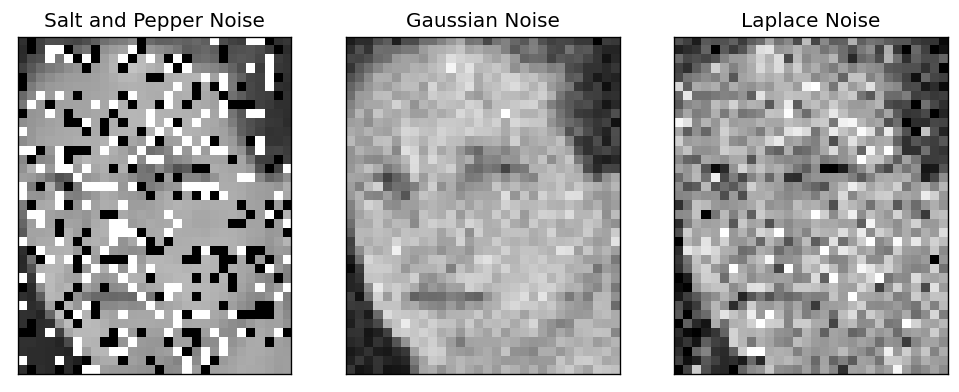

In [ ]:
# Example noise
plt.figure(figsize=(10,10), dpi=120)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
      
    if i == 0:
      X_noisy = salt_pepper_noise(X, p=0.3, s_vs_p=0.5)
      title = "Salt and Pepper Noise"
    elif i == 1:
      X_noisy = gaussian_noise_2d(X, mean=0, sigma=0.05)
      title = "Gaussian Noise"
    else:
      X_noisy = laplace_noise(X, loc=0, scale=0.11)
      title = "Laplace Noise"

    test_img_noise = array2img(X_noisy[:, 0], 
                               h=img_size[0],
                               w=img_size[1])

    # Set title
    plt.title(f'{title}', fontsize=12)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

### 2.2.- Metric Functions

This section contains the needed functions to calculate the different metrics. We implement and use three evaluation metrics:

- **Relative  Reconstruction  Errors  (RRE)**

  \begin{equation}
    RRE=\frac{\|\widehat{X} - UV\|_F}{\|\widehat{X}\|_F}
  \end{equation}

- **Average Accuracy**

  \begin{equation}
    ACC(Y, Y_{pred})=\frac{1}{n}\sum\limits_{i=1}^n1\{Y_{pred}(i) == Y(i)\}
  \end{equation}

- **Normalized Mutual Information (NMI)**

  \begin{equation}
    NMI(Y, Y_{pred})=\frac{2 \ast I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}
  \end{equation}

In [ ]:
def assign_cluster_label(X, Y):
  kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

def rre(X_true, X_rec):
  """
  Function to compute reconstruction error.

  :param X_true: Original X
  :param X_rec: Reconstructed Data - X_hat
  """
  return np.linalg.norm(X_true - X_rec, ord="fro") / np.linalg.norm(X_true)

def accuracy(Y_true, Y_pred):
  """
  Function to compute accuracy.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return Accuracy
  """
  return accuracy_score(Y_true, Y_pred)

def nmi_score(Y_true, Y_pred):
  """
  Function to compute Normalized Mutual Information metric.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return NMI
  """
  return normalized_mutual_info_score(Y_true, Y_pred)

def evaluate(X, X_rec, Y_true, H):
  """
  Function to compute RRE, Average Accuracy and NMI.

  :param X: Original X
  :param X_rec: Reconstructed X
  :param Y_true: Original Y
  :param H: V matrix
  :return RRE, acc, NMI
  """
  Y_pred = assign_cluster_label(H.T, Y_true)
  rre_metric = rre(X, X_rec)
  acc_metric = accuracy(Y_true, Y_pred)
  nmi_metric = nmi_score(Y_true, Y_pred)
  return rre_metric, acc_metric, nmi_metric

## 3.- Non-negative Matrix Factorization

In this section, we present the implementation of the two Non-negative Matrix Factorization algorithms. A detailed formulation of each one are provided in the report.

### 3.1.- L2-Norm NMF


In [ ]:
class L2NMF():
  def __init__(self):
      pass

  def reconstruct_data(self, W, H):
      """
      Function to reconstruct data from W. H

      :param W: W matrix
      :param H: H matrix

      :return X_hat: Reconstructed Data
      """
      return W.dot(H)

  def SVDbased_init(self, X, rank):
      """
      Function SVD based initiation

      :param W: W matrix
      :param H: H matrix

      :return X_hat: Reconstructed Data
      """
      u,s,v=np.linalg.svd(X,full_matrices=False)
      v=v.T
      w=np.zeros((X.shape[0],rank))
      h=np.zeros((rank,X.shape[1]))

      w[:,0]=np.sqrt(s[0])*np.abs(u[:,0])
      h[0,:]=np.sqrt(s[0])*np.abs(v[:,0].T)

      for i in range(1,rank):
          
          ui=u[:,i]
          vi=v[:,i]
          ui_pos=(ui>=0)*ui
          ui_neg=(ui<0)*-ui
          vi_pos=(vi>=0)*vi
          vi_neg=(vi<0)*-vi
          
          ui_pos_norm=np.linalg.norm(ui_pos,2)
          ui_neg_norm=np.linalg.norm(ui_neg,2)
          vi_pos_norm=np.linalg.norm(vi_pos,2)
          vi_neg_norm=np.linalg.norm(vi_neg,2)
          
          norm_pos=ui_pos_norm*vi_pos_norm
          norm_neg=ui_neg_norm*vi_neg_norm
          
          if norm_pos>=norm_neg:
              w[:,i]=np.sqrt(s[i]*norm_pos)/ui_pos_norm*ui_pos
              h[i,:]=np.sqrt(s[i]*norm_pos)/vi_pos_norm*vi_pos.T
          else:
              w[:,i]=np.sqrt(s[i]*norm_neg)/ui_neg_norm*ui_neg
              h[i,:]=np.sqrt(s[i]*norm_neg)/vi_neg_norm*vi_neg.T
      return w, h

  def random_init(self, X, rank):
      """
      Function to initiate randomly

      :param X: input matrix
      :param rank: components

      """
      number_of_features = X.shape[0]
      number_of_observations = X.shape[1]

      W = np.random.uniform(1,2,(number_of_features,self.rank))
      H = np.random.uniform(1,2,(self.rank,number_of_observations))
      return W, H

  # L2 Multiplicative NMF
  def compute(self, X):
      
      """
      Function to NMF X ~ WH

      :param X: input matrix (feats x samples)
      :param k: number of component/rank
      :param n_inter: number of interation
      
      """     
      W, H = self.SVDbased_init(X, self.rank)
      #W, H = self.random_init(X, self.rank)
      k = self.rank
      e = 1.0e-10
      
      self.loss = []
      rre_metric = []
      acc_metric = []
      nmi_metric = []

      for n in range(self.n_iter):
          # Update H
          W_TX = W.T@X
          W_TWH = W.T@W@H+e
          for i in range(np.size(H, 0)):
              for j in range(np.size(H, 1)):
                  H[i, j] = H[i, j] * W_TX[i, j] / W_TWH[i, j]

          # Update W
          XH_T = X@H.T
          WHH_T =  W@H@H.T+ e

          for i in range(np.size(W, 0)):
              for j in range(np.size(W, 1)):
                  W[i, j] = W[i, j] * XH_T[i, j] / WHH_T[i, j]

          norm = np.linalg.norm(X - W@H, 'fro')
          self.loss.append(norm)
      
          # Print loss
          if n % 5 == 0:
            # Calculate Metrics
            rre_vle, acc_vle, nmi_vle = evaluate(self.X, self.reconstruct_data(W, H), 
                                                self.Y, H)
            #loss_vla = rre(X, self.reconstruct_data(U, V, E))
            rre_metric.append((n, round(rre_vle, 3)))
            acc_metric.append((n, round(acc_vle, 3)))
            nmi_metric.append((n, round(nmi_vle, 3)))
            print(f"Iteration: {n} - Error: {round(rre_vle, 3)} - Acc: {round(acc_vle, 3)} - NMI: {round(nmi_vle, 3)}")
      return W, H, rre_metric, acc_metric, nmi_metric

  def fit(self, X, X_noisy, Y, n_components,
          n_iter, 
          plot=True):
      """
      Function to compute W H

      :param X: Data
      :param X: Data with added noise
      :param Y: True label
      :param n_components: Number of components
      :param n_iter: Number of iterations
      :param plot: To plot the loss
      :return W, H Matrices
      """

      # Initialize data
      self.X = X
      self.X_noisy = X_noisy
      self.Y = Y
      self.n_iter = n_iter
      self.rank = n_components

      W, H, rre_metric, acc_metric, nmi_metric = self.compute(X_noisy)
      self.W = W
      self.H = H

      if plot:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
        axs[0].plot([el[0] for el in rre_metric], [el[1] for el in rre_metric])
        axs[1].plot([el[0] for el in acc_metric], [el[1] for el in acc_metric])
        axs[2].plot([el[0] for el in nmi_metric], [el[1] for el in nmi_metric])
        axs[0].set_title('Reconstruction Error')
        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('RRE')

        axs[1].set_title('Acccuracy')
        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('ACC')

        axs[2].set_title('Normalized Mutual Information')
        axs[2].set_xlabel('Iterations')
        axs[2].set_ylabel('NMI')
        fig.tight_layout()
      return W, H

  def transform(self, X, iter=100):
      W = self.W
      number_of_features = X.shape[0]
      number_of_observations = X.shape[1]

      H = np.random.uniform(1,2,(self.rank,number_of_observations))

      e = 1.0e-10
      for n in range(self.n_iter):
          # Update H
          W_TX = W.T@X
          W_TWH = W.T@W@H+e
          for i in range(np.size(H, 0)):
              for j in range(np.size(H, 1)):
                  H[i, j] = H[i, j] * W_TX[i, j] / W_TWH[i, j]
      
      return H

Testing our implementation

Iteration: 0 - Error: 0.232 - Acc: 0.692 - NMI: 0.821
Iteration: 5 - Error: 0.212 - Acc: 0.697 - NMI: 0.825
Iteration: 10 - Error: 0.202 - Acc: 0.678 - NMI: 0.81
Iteration: 15 - Error: 0.197 - Acc: 0.692 - NMI: 0.817
Iteration: 20 - Error: 0.192 - Acc: 0.689 - NMI: 0.829
Iteration: 25 - Error: 0.189 - Acc: 0.722 - NMI: 0.842
Iteration: 30 - Error: 0.187 - Acc: 0.703 - NMI: 0.826
Iteration: 35 - Error: 0.184 - Acc: 0.731 - NMI: 0.837


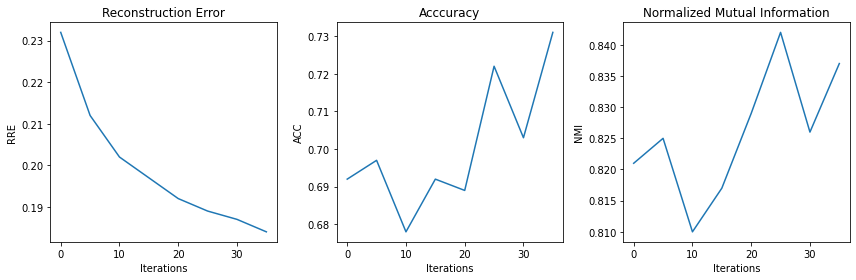

In [ ]:
# Add noise to original images
X_noisy = gaussian_noise_2d(X, mean=0, sigma=0.05)

# Initialize algorithm
L2MUR = L2NMF()

# Run it
W, H = L2MUR.fit(X=X, 
                 X_noisy=X_noisy, 
                 Y=Y, 
                 n_components=30, 
                 n_iter=40)

# Reconstruct image
X_hat = L2MUR.reconstruct_data(W, H)

L2 loss


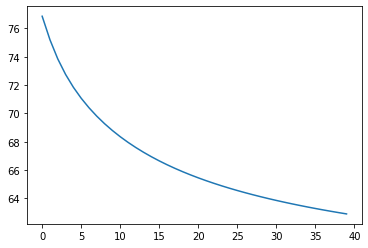

In [ ]:
print("L2 loss")
plt.plot(L2MUR.loss)

In [ ]:
rre_metric, acc_metric, nmi_metric = evaluate(X=X, X_rec=X_hat, Y_true=Y, H=H)

print(f"Reconstruction Error: {rre_metric}")
print(f"Accuracy: {acc_metric}")
print(f"Normalized mutual information: {nmi_metric}")

Reconstruction Error: 0.18299925733812455
Accuracy: 0.7055555555555556
Normalized mutual information: 0.8343354992819586


Plotting the original, basis and reconstructed image.

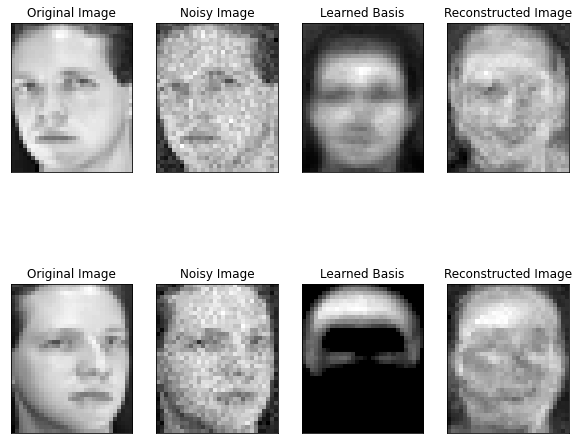

In [ ]:
# Reduce Factor = 3
img_size = [i//3 for i in (92, 112)] # ORL

n_imgs = 2

fig, axs = plt.subplots(nrows=n_imgs, ncols=4, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
for n in range(n_imgs):
    # Plot original data
    org_data = array2img(X[:, n], h=img_size[0], w=img_size[1])
    axs[n,0].imshow(org_data, cmap=plt.cm.gray)
    axs[n,0].set_xticks([])
    axs[n,0].set_yticks([])
    axs[n,0].set_title('Original Image')

    # Plot noisy image
    org_data = array2img(X_noisy[:, n], h=img_size[0], w=img_size[1])
    axs[n,1].imshow(org_data, cmap=plt.cm.gray)
    axs[n,1].set_xticks([])
    axs[n,1].set_yticks([])
    axs[n,1].set_title('Noisy Image')

    # Plot basis image
    rest_data = array2img(W[:, n], h=img_size[0], w=img_size[1])
    axs[n,2].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,2].set_xticks([])
    axs[n,2].set_yticks([])
    axs[n,2].set_title('Learned Basis')

    # Plot reconstructed image
    rest_data = array2img(X_hat[:, n], h=img_size[0], w=img_size[1])
    axs[n,3].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,3].set_xticks([])
    axs[n,3].set_yticks([])
    axs[n,3].set_title('Reconstructed Image')

### 3.2.- KL-NMF


In [ ]:
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    
    p = np.asarray(p, dtype=float)/sum(p)
    q = np.asarray(q, dtype=float)/sum(q)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

class KLNMF():
  def __init__(self):
      pass

  def reconstruct_data(self, W, H):
      """
      Function to reconstruct data from W. H

      :param W: W matrix
      :param H: H matrix

      :return X_hat: Reconstructed Data
      """
      return W.dot(H)

  def SVDbased_init(self, X, rank):
      """
      Function SVD based initiation

      :param W: W matrix
      :param H: H matrix

      :return X_hat: Reconstructed Data
      """
      u,s,v=np.linalg.svd(X,full_matrices=False)
      v=v.T
      w=np.zeros((X.shape[0],rank))
      h=np.zeros((rank,X.shape[1]))

      w[:,0]=np.sqrt(s[0])*np.abs(u[:,0])
      h[0,:]=np.sqrt(s[0])*np.abs(v[:,0].T)

      for i in range(1,rank):
          
          ui=u[:,i]
          vi=v[:,i]
          ui_pos=(ui>=0)*ui
          ui_neg=(ui<0)*-ui
          vi_pos=(vi>=0)*vi
          vi_neg=(vi<0)*-vi
          
          ui_pos_norm=np.linalg.norm(ui_pos,2)
          ui_neg_norm=np.linalg.norm(ui_neg,2)
          vi_pos_norm=np.linalg.norm(vi_pos,2)
          vi_neg_norm=np.linalg.norm(vi_neg,2)
          
          norm_pos=ui_pos_norm*vi_pos_norm
          norm_neg=ui_neg_norm*vi_neg_norm
          
          if norm_pos>=norm_neg:
              w[:,i]=np.sqrt(s[i]*norm_pos)/ui_pos_norm*ui_pos
              h[i,:]=np.sqrt(s[i]*norm_pos)/vi_pos_norm*vi_pos.T
          else:
              w[:,i]=np.sqrt(s[i]*norm_neg)/ui_neg_norm*ui_neg
              h[i,:]=np.sqrt(s[i]*norm_neg)/vi_neg_norm*vi_neg.T
      return w, h

  def random_init(self, X, rank):
      """
      Function to initiate randomly

      :param X: input matrix
      :param rank: components

      """
      number_of_features = X.shape[0]
      number_of_observations = X.shape[1]

      W = np.random.uniform(1,2,(number_of_features,self.rank))
      H = np.random.uniform(1,2,(self.rank,number_of_observations))
      return W, H

  # KL Multiplicative NMF
  def compute(self, X):
      
      """
      Function to NMF X ~ WH

      :param X: input matrix (feats x samples)
      :param k: number of component/rank
      :param n_inter: number of interation
      
      """     
      W, H = self.SVDbased_init(X, self.rank)
     #W, H = self.random_init(X, self.rank)
      k = self.rank
      e = 1.0e-10
      
      self.loss = []
      rre_metric = []
      acc_metric = []
      nmi_metric = []

      for n in range(self.n_iter):

          # Update W, H  
          ones = np.ones(X.shape)
          W *= (((X / (W @ H + e)) @ H.T) / (ones @ H.T + e))            
          H *= ((W.T @ (X / (W @ H + e))) / (W.T @ ones + e))          

          self.loss.append(kl(X, W@H))

          # Print loss
          if n % 5 == 0:
            # Calculate Metrics
            rre_vle, acc_vle, nmi_vle = evaluate(self.X, self.reconstruct_data(W, H), 
                                                self.Y, H)
            #loss_vla = rre(X, self.reconstruct_data(U, V, E))
            rre_metric.append((n, round(rre_vle, 3)))
            acc_metric.append((n, round(acc_vle, 3)))
            nmi_metric.append((n, round(nmi_vle, 3)))
            print(f"Iteration: {n} - Error: {round(rre_vle, 3)} - Acc: {round(acc_vle, 3)} - NMI: {round(nmi_vle, 3)}")
      return W, H, rre_metric, acc_metric, nmi_metric

  def fit(self, X, X_noisy, Y, n_components,
          n_iter, 
          plot=True):
      """
      Function to compute W H

      :param X: Data
      :param X: Data with added noise
      :param Y: True label
      :param n_components: Number of components
      :param n_iter: Number of iterations
      :param plot: To plot the loss
      :return W, H Matrices
      """

      # Initialize data
      self.X = X
      self.X_noisy = X_noisy
      self.Y = Y
      self.n_iter = n_iter
      self.rank = n_components

      W, H, rre_metric, acc_metric, nmi_metric = self.compute(X_noisy)
      self.W = W
      self.H = H

      if plot:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
        axs[0].plot([el[0] for el in rre_metric], [el[1] for el in rre_metric])
        axs[1].plot([el[0] for el in acc_metric], [el[1] for el in acc_metric])
        axs[2].plot([el[0] for el in nmi_metric], [el[1] for el in nmi_metric])
        axs[0].set_title('Reconstruction Error')
        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('RRE')

        axs[1].set_title('Acccuracy')
        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('ACC')

        axs[2].set_title('Normalized Mutual Information')
        axs[2].set_xlabel('Iterations')
        axs[2].set_ylabel('NMI')
        fig.tight_layout()
      return W, H

  def transform(self, X, iter=100):
      W = self.W
      number_of_features = X.shape[0]
      number_of_observations = X.shape[1]

      H = np.random.uniform(1,2,(self.rank,number_of_observations))

      e = 1.0e-10
      for n in range(self.n_iter):
          # Update H
          ones = np.ones(X.shape)
          H *= ((W.T @ (X / (W @ H + e))) / (W.T @ ones + e))           
      
      return H

Testing our implementation

Iteration: 0 - Error: 0.231 - Acc: 0.689 - NMI: 0.824
Iteration: 5 - Error: 0.211 - Acc: 0.681 - NMI: 0.818
Iteration: 10 - Error: 0.201 - Acc: 0.7 - NMI: 0.826
Iteration: 15 - Error: 0.196 - Acc: 0.722 - NMI: 0.848
Iteration: 20 - Error: 0.192 - Acc: 0.742 - NMI: 0.857
Iteration: 25 - Error: 0.188 - Acc: 0.742 - NMI: 0.856
Iteration: 30 - Error: 0.186 - Acc: 0.769 - NMI: 0.869
Iteration: 35 - Error: 0.184 - Acc: 0.761 - NMI: 0.859


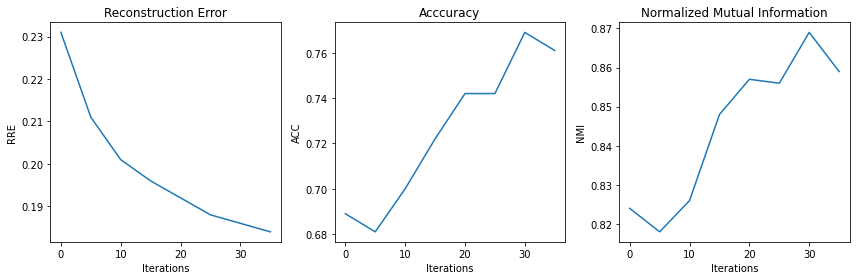

In [ ]:
# Add noise to original images
X_noisy = gaussian_noise_2d(X, mean=0, sigma=0.05)

# Initialize algorithm
KLMUR = KLNMF()

# Run it
W, H = KLMUR.fit(X=X, 
                 X_noisy=X_noisy, 
                 Y=Y, 
                 n_components=30, 
                 n_iter=40)

# Reconstruct image
X_hat = KLMUR.reconstruct_data(W, H)

KL loss


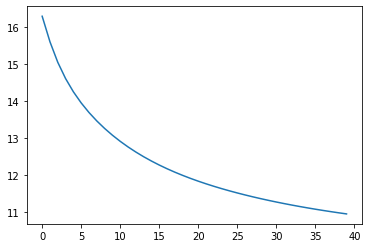

In [ ]:
print("KL loss")
plt.plot(KLMUR.loss)

In [ ]:
rre_metric, acc_metric, nmi_metric = evaluate(X=X, X_rec=X_hat, Y_true=Y, H=H)

print(f"Reconstruction Error: {rre_metric}")
print(f"Accuracy: {acc_metric}")
print(f"Normalized mutual information: {nmi_metric}")

Reconstruction Error: 0.18279568025893295
Accuracy: 0.725
Normalized mutual information: 0.8477684178730531


Plotting the original, basis and reconstructed image.

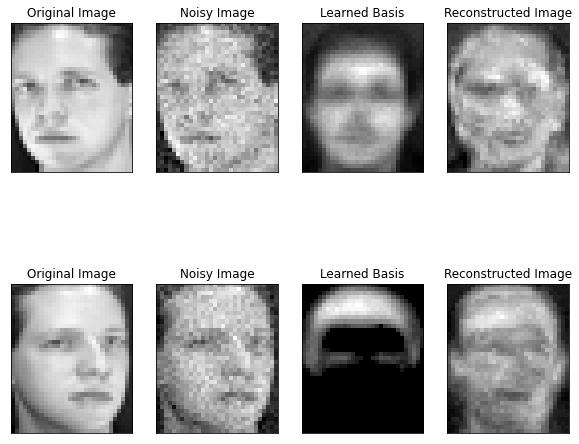

In [ ]:
# Reduce Factor = 3
img_size = [i//3 for i in (92, 112)] # ORL

n_imgs = 2

fig, axs = plt.subplots(nrows=n_imgs, ncols=4, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
for n in range(n_imgs):
    # Plot original data
    org_data = array2img(X[:, n], h=img_size[0], w=img_size[1])
    axs[n,0].imshow(org_data, cmap=plt.cm.gray)
    axs[n,0].set_xticks([])
    axs[n,0].set_yticks([])
    axs[n,0].set_title('Original Image')

    # Plot noisy image
    org_data = array2img(X_noisy[:, n], h=img_size[0], w=img_size[1])
    axs[n,1].imshow(org_data, cmap=plt.cm.gray)
    axs[n,1].set_xticks([])
    axs[n,1].set_yticks([])
    axs[n,1].set_title('Noisy Image')

    # Plot basis image
    rest_data = array2img(W[:, n], h=img_size[0], w=img_size[1])
    axs[n,2].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,2].set_xticks([])
    axs[n,2].set_yticks([])
    axs[n,2].set_title('Learned Basis')

    # Plot reconstructed image
    rest_data = array2img(X_hat[:, n], h=img_size[0], w=img_size[1])
    axs[n,3].imshow(rest_data, cmap=plt.cm.gray)
    axs[n,3].set_xticks([])
    axs[n,3].set_yticks([])
    axs[n,3].set_title('Reconstructed Image')

## 4.- Experiments

This section contains the experiments performed using the different algorithms implemented before. In this case, we will use the ORL and Yale face datasets and we will measure the performance and robustness of each algorithm.

In [ ]:
def random_sample(X, y, size=0.9):
  """
  Function to randomly sampling data from X

  :param X: X data
  :param y: y data
  :param size: Percentage
  """

  # Get index
  idx = np.arange(X.shape[1])
  # Randomly shuffle idx
  np.random.shuffle(idx)
  # Get data
  idx_rand = idx[0:int(len(idx)*size)]

  X_sample, y_sample = X[:, idx_rand], y[idx_rand]
  return X_sample, y_sample

In [ ]:
def assign_cluster_label(X, Y):
  kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

def rre(X_true, X_rec):
  """
  Function to compute reconstruction error.
  
  :param X_true: Original Y
  :param X_rec: Reconstructed Data - X_hat
  """
  return np.linalg.norm(X_true - X_rec, ord="fro") / np.linalg.norm(X_true)

def accuracy(Y_true, Y_pred):
  """
  Function to compute accuracy.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return Accuracy
  """
  return accuracy_score(Y_true, Y_pred)

def nmi_score(Y_true, Y_pred):
  """
  Function to compute Normalized Mutual Information metric.

  :param Y_true: Original Y
  :param Y_pred: Y obtained using k-means
  :return NMI
  """
  return normalized_mutual_info_score(Y_true, Y_pred)

def evaluate(X, X_rec, Y_true, H):
  """
  Function to compute RRE, Average Accuracy and NMI.

  :param X: Original X
  :param X_rec: Reconstructed X
  :param Y_true: Original Y
  :param H: V matrix
  :return RRE, acc, NMI
  """
  Y_pred = assign_cluster_label(H.T, Y_true)
  rre_metric = rre(X, X_rec)
  acc_metric = accuracy(Y_true, Y_pred)
  nmi_metric = nmi_score(Y_true, Y_pred)
  return rre_metric, acc_metric, nmi_metric

def display(X, X_noisy, X_reconstructed, img_size, n_imgs=3):
  """
  Function to visualize X, X_noisy and X_reconstructed at the same time
  :param X: X data
  :param X_noise: X with noise
  :param X_reconstructed: Reconstructed X
  :return plot
  """

  fig, axs = plt.subplots(nrows=n_imgs, ncols=3, figsize=(10, 15))
  plt.subplots_adjust(hspace=0.5)
  for n in range(n_imgs):
      # Plot original data
      org_data = array2img(X[:, n], h=img_size[0], w=img_size[1])
      axs[n,0].imshow(org_data, cmap=plt.cm.gray)
      axs[n,0].set_xticks([])
      axs[n,0].set_yticks([])
      axs[n,0].set_title('Original Image')

      # Plot noisy image
      rest_data = array2img(X_noisy[:, n], h=img_size[0], w=img_size[1])
      axs[n,1].imshow(rest_data, cmap=plt.cm.gray)
      axs[n,1].set_xticks([])
      axs[n,1].set_yticks([])
      axs[n,1].set_title('Noisy Image')

      # Plot reconstructed image
      rest_data = array2img(X_reconstructed[:, n], h=img_size[0], w=img_size[1])
      axs[n,2].imshow(rest_data, cmap=plt.cm.gray)
      axs[n,2].set_xticks([])
      axs[n,2].set_yticks([])
      axs[n,2].set_title('Reconstructed Image')
  return

In [ ]:
def reconstruct_data(U, V):
  """
  Function to reconstruct data from U, V

  :param U: U matrix
  :param V: V matrix
  :return X_hat: Reconstructed Data
  """
  return U.dot(V)


def fit_nmf(X, X_noisy, Y, model, reg_param, n_components, iters):
  """
  Function to fit the nmf models

  :param X: Original Data - For calculating metrics
  :param X_noisy: Data with noise
  :param Y: Original Label - For calculating metrics
  :param model: Type of model
  :param reg_param: Regularization Parameter (not used)
  :param n_components: Number of components
  :param iter: iterations
  :return model
  """

  if model.lower() == "l2":
    
    L2MUR = L2NMF()
    W, H = L2MUR.fit( X=X, 
                      X_noisy=X_noisy, 
                      Y=Y, 
                      n_components=n_components, 
                      n_iter=iters, 
                      plot=False)
    return W, H

  elif model.lower() == "kl":

    KLMUR = KLNMF()
    W, H = KLMUR.fit(X=X, 
                      X_noisy=X_noisy, 
                      Y=Y, 
                      n_components=n_components, 
                      n_iter=iters,
                      plot=False)
    return W, H

  else:
    print('Unknown Model Type. Insert: l2 or kl')

  return

In [ ]:
def run_experiment(alg="all", 
                   n_experiment=3, 
                   size_data=0.9, 
                   n_iters=400, 
                   n_components=40,
                   type_noise="gaussian2d",
                   **kwarg):
  """
  Function to perform the experiments

  :param alg: List of algorithms
  :param n_experiment: Number of experiments
  :param size_data: Size of randomly sample data
  :param n_iters: Number of iterations
  :param n_components: Number of components
  :param type_noise: Type of Noise
  :return result_metrics: Mean values of each experiment
  """

  if alg=="all":
    alg = ['l2', 'kl']

  print(f"Parameters: {kwarg['kwarg']}", )

  mean_result_metrics = []
  std_result_metrics = []
  for alg_nmf in alg:
    print(f"Running experiments for: {alg_nmf}")
    print("--------------------------------------------")
    rre_metric = []
    acc_metric = []
    nmi_metric = []
    for n in range(n_experiment):
      print(f"\nExperiment number: {n+1}")
      print("-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-")

      # 1 randomly sample data
      X_sample, y_sample = random_sample(X, Y, size=size_data)

      # 2 add noise
      if type_noise.lower()=="salt_pepper":
        if kwarg:
          X_noisy = salt_pepper_noise(X_sample, 
                                      p=kwarg['kwarg']['p'], 
                                      s_vs_p=kwarg['kwarg']['s_vs_p'])
        else:
          X_noisy = salt_pepper_noise(X_sample)

      elif type_noise.lower()=='gaussian2d': 
        if kwarg:
          X_noisy = gaussian_noise_2d(X_sample, 
                                      mean=kwarg['kwarg']['mean'], 
                                      sigma=kwarg['kwarg']['sigma'])
        else:
          X_noisy = gaussian_noise_2d(X_sample)        
      
      elif type_noise.lower()=='laplace':
        if kwarg:
          X_noisy = laplace_noise(X_sample, 
                                  loc=kwarg['kwarg']['loc'], 
                                  scale=kwarg['kwarg']['scale'])
        else:
          X_noisy = laplace_noise(X_sample)

      # 3 Fit NMF
      U, V = fit_nmf(X=X_sample, 
                        X_noisy=X_noisy, 
                        Y=y_sample,
                        model=alg_nmf, 
                        n_components=n_components, 
                        iters=n_iters,
                        reg_param=kwarg['kwarg']['reg_param'])

      # 4 Reconstruct and Evaluate
      X_hat = reconstruct_data(U, V)
      rre_, acc_, nmi_ = evaluate(X=X_sample, 
                                  X_rec=X_hat, 
                                  Y_true=y_sample, 
                                  H=V)
      
      # Append metrics for each iteration
      rre_metric.append(rre_)
      acc_metric.append(acc_)
      nmi_metric.append(nmi_)

    # Append mean value
    mean_result_metrics.append([np.mean(rre_metric), np.mean(acc_metric), np.mean(nmi_metric)])
    std_result_metrics.append([np.std(rre_metric), np.std(acc_metric), np.std(nmi_metric)])

    print(f"\nMean Values - RRE: {np.mean(rre_metric)} - ACC: {np.mean(acc_metric)} - NMI: {np.mean(nmi_metric)}")
    print("--------------------------------------------")
  return mean_result_metrics, std_result_metrics

### 4.1.- Classification with SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

Utils functions

In [ ]:
def classification_svc(X_train_model, y_train):
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_model, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    return clf

def prediction(model, data):
    print("Predicting faces on the test set")
    t0 = time()
    y_pred = model.predict(data)
    print("done in %0.3fs" % (time() - t0))

    return y_pred

def plot_images(images, titles, height, width, n_row=1, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

    plt.show()

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]]
    true_name = target_names[y_test[i]]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

Prepare data

In [12]:
X_train, Y_train = load_data("data/orl_faces/Training", reduce=3)
X_test, Y_test = load_data("data/orl_faces/Testing", reduce=3)
X_train.shape, Y_train.shape

((1110, 360), (360,))

In [ ]:
# Reduce Factor = 3
width, height = [i//3 for i in (92, 112)] # ORL
height, width

(37, 30)

In [ ]:
n_classes = len(set(Y_train))
target_names = [f"Person {i+1}" for i in range(n_classes)]
target_names[:5]

['Person 1', 'Person 2', 'Person 3', 'Person 4', 'Person 5']

#### Vanila SVM 

In [ ]:
# Training a SVM classification model
clf = classification_svc(X_train.T, Y_train)

# Quantitative evaluation of the model quality on the test set
Y_pred = prediction(clf, X_test.T)

# printing classification report
print(classification_report(Y_test, Y_pred, target_names=target_names, zero_division=0))

Fitting the classifier to the training set
done in 12.194s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)
Predicting faces on the test set
done in 0.020s
              precision    recall  f1-score   support

    Person 1       1.00      1.00      1.00         1
    Person 2       0.00      0.00      0.00         1
    Person 3       1.00      1.00      1.00         1
    Person 4       1.00      1.00      1.00         1
    Person 5       1.00      1.00      1.00         1
    Person 6       1.00      1.00      1.00         1
    Person 7       1.00      1.00      1.00         1
    Person 8       1.00      1.00      1.00         1
    Person 9       1.00      1.00      1.00         1
   Person 10       0.50      1.00      0.67         1
   Person 11       1.00      1.00      1.00         1
   Person 12       1.00      1.00      1.00         1
   Person 13       1.00      1.00      1.00         1
   Person 14       1.00      1.00      1.00   

#### L2NMF

In [ ]:
# Initialize algorithm
L2MUR = L2NMF()

# Run it
W, H = L2MUR.fit(X=X_train, 
                 X_noisy=X_train, 
                 Y=Y_train, 
                 n_components=40, 
                 n_iter=40,
                 plot=False)

Iteration: 0 - Error: 0.23 - Acc: 0.711 - NMI: 0.837
Iteration: 5 - Error: 0.209 - Acc: 0.756 - NMI: 0.857
Iteration: 10 - Error: 0.198 - Acc: 0.697 - NMI: 0.827
Iteration: 15 - Error: 0.191 - Acc: 0.664 - NMI: 0.82
Iteration: 20 - Error: 0.186 - Acc: 0.725 - NMI: 0.844
Iteration: 25 - Error: 0.182 - Acc: 0.725 - NMI: 0.849
Iteration: 30 - Error: 0.179 - Acc: 0.725 - NMI: 0.855
Iteration: 35 - Error: 0.176 - Acc: 0.761 - NMI: 0.865


In [ ]:
t0 = time()
X_train_nmf = L2MUR.transform(X_train).T
X_test_nmf = L2MUR.transform(X_test).T
print("done in %0.3fs" % (time() - t0))

done in 2.165s


In [ ]:
# Training a SVM classification model
clf = classification_svc(X_train_nmf, Y_train)

Fitting the classifier to the training set
done in 3.367s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [ ]:
# Quantitative evaluation of the model quality on the test set
Y_pred = prediction(clf, X_test_nmf)

Predicting faces on the test set
done in 0.003s


In [ ]:
# printing classification report
print(classification_report(Y_test, Y_pred, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

    Person 1       0.00      0.00      0.00         1
    Person 2       0.00      0.00      0.00         1
    Person 3       1.00      1.00      1.00         1
    Person 4       1.00      1.00      1.00         1
    Person 5       1.00      1.00      1.00         1
    Person 6       1.00      1.00      1.00         1
    Person 7       1.00      1.00      1.00         1
    Person 8       0.50      1.00      0.67         1
    Person 9       1.00      1.00      1.00         1
   Person 10       0.50      1.00      0.67         1
   Person 11       1.00      1.00      1.00         1
   Person 12       1.00      1.00      1.00         1
   Person 13       1.00      1.00      1.00         1
   Person 14       1.00      1.00      1.00         1
   Person 15       1.00      1.00      1.00         1
   Person 16       1.00      1.00      1.00         1
   Person 17       1.00      1.00      1.00         1
   Person 18       1.00    

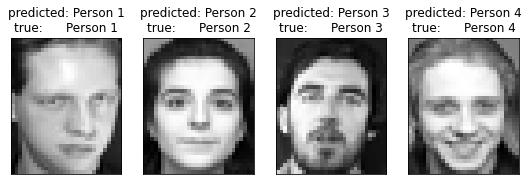

In [ ]:
# printing images`
prediction_titles = [title(Y_pred, Y_test, target_names, i)
                     for i in range(Y_pred.shape[0])]

plot_images(X_test.T, prediction_titles, height, width)

#### KLNMF

In [ ]:
# Initialize algorithm
KLMUR = KLNMF()

# Run it
W, H = KLMUR.fit(X=X_train, 
                 X_noisy=X_train, 
                 Y=Y_train, 
                 n_components=40, 
                 n_iter=40,
                 plot=False)

Iteration: 0 - Error: 0.229 - Acc: 0.722 - NMI: 0.856
Iteration: 5 - Error: 0.207 - Acc: 0.686 - NMI: 0.812
Iteration: 10 - Error: 0.197 - Acc: 0.7 - NMI: 0.847
Iteration: 15 - Error: 0.19 - Acc: 0.7 - NMI: 0.826
Iteration: 20 - Error: 0.185 - Acc: 0.719 - NMI: 0.864
Iteration: 25 - Error: 0.182 - Acc: 0.7 - NMI: 0.84
Iteration: 30 - Error: 0.179 - Acc: 0.747 - NMI: 0.86
Iteration: 35 - Error: 0.176 - Acc: 0.728 - NMI: 0.858


In [ ]:
t0 = time()
X_train_nmf = KLMUR.transform(X_train).T
X_test_nmf = KLMUR.transform(X_test).T
print("done in %0.3fs" % (time() - t0))

done in 0.345s


In [ ]:
# Training a SVM classification model
clf = classification_svc(X_train_nmf, Y_train)

Fitting the classifier to the training set
done in 3.359s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)


In [ ]:
# Quantitative evaluation of the model quality on the test set
Y_pred = prediction(clf, X_test_nmf)

Predicting faces on the test set
done in 0.004s


In [ ]:
# printing classification report
print(classification_report(Y_test, Y_pred, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

    Person 1       1.00      1.00      1.00         1
    Person 2       0.00      0.00      0.00         1
    Person 3       1.00      1.00      1.00         1
    Person 4       1.00      1.00      1.00         1
    Person 5       1.00      1.00      1.00         1
    Person 6       1.00      1.00      1.00         1
    Person 7       1.00      1.00      1.00         1
    Person 8       1.00      1.00      1.00         1
    Person 9       1.00      1.00      1.00         1
   Person 10       1.00      1.00      1.00         1
   Person 11       1.00      1.00      1.00         1
   Person 12       1.00      1.00      1.00         1
   Person 13       1.00      1.00      1.00         1
   Person 14       1.00      1.00      1.00         1
   Person 15       1.00      1.00      1.00         1
   Person 16       1.00      1.00      1.00         1
   Person 17       1.00      1.00      1.00         1
   Person 18       1.00    

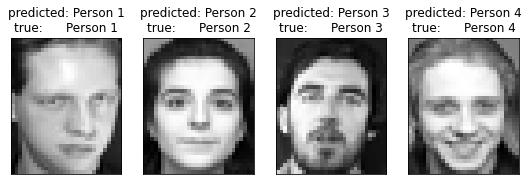

In [ ]:
# printing images`
prediction_titles = [title(Y_pred, Y_test, target_names, i)
                     for i in range(Y_pred.shape[0])]

plot_images(X_test.T, prediction_titles, height, width)

#### with the Yale dataset

In [13]:
X_train, Y_train = load_data("data/yale_faces/Training", reduce=3)
X_test, Y_test = load_data("data/yale_faces/Testing", reduce=3)

# Reduce Factor = 3
width, height = [i//3 for i in (320, 243)] # Yale

n_classes = len(set(Y_train))
target_names = [f"Person {i+1}" for i in range(n_classes)]

In [ ]:
# Training a SVM classification model
clf = classification_svc(X_train.T, Y_train)

# Quantitative evaluation of the model quality on the test set
Y_pred = prediction(clf, X_test.T)

# printing classification report
print(classification_report(Y_test, Y_pred, target_names=target_names, zero_division=0))

Fitting the classifier to the training set
done in 15.959s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)
Predicting faces on the test set
done in 0.016s
              precision    recall  f1-score   support

    Person 1       1.00      1.00      1.00         1
    Person 2       1.00      1.00      1.00         1
    Person 3       0.00      0.00      0.00         1
    Person 4       1.00      1.00      1.00         1
    Person 5       1.00      1.00      1.00         1
    Person 6       0.00      0.00      0.00         1
    Person 7       0.50      1.00      0.67         1
    Person 8       0.33      1.00      0.50         1
    Person 9       0.00      0.00      0.00         1
   Person 10       1.00      1.00      1.00         1
   Person 11       1.00      1.00      1.00         1
   Person 12       1.00      1.00      1.00         1
   Person 13       1.00      1.00      1.00         1
   Person 14       1.00      1.00      1.00   

In [ ]:
# Initialize algorithm
L2MUR = L2NMF()

# Run it
W, H = L2MUR.fit(X=X_train, 
                 X_noisy=X_train, 
                 Y=Y_train, 
                 n_components=40, 
                 n_iter=40,
                 plot=False)
t0 = time()
X_train_nmf = L2MUR.transform(X_train).T
X_test_nmf = L2MUR.transform(X_test).T
print("done in %0.3fs" % (time() - t0))

# Training a SVM classification model
clf = classification_svc(X_train_nmf, Y_train)

# Quantitative evaluation of the model quality on the test set
Y_pred = prediction(clf, X_test_nmf)

# printing classification report
print(classification_report(Y_test, Y_pred, target_names=target_names, zero_division=0))

Iteration: 0 - Error: 0.246 - Acc: 0.629 - NMI: 0.646
Iteration: 5 - Error: 0.211 - Acc: 0.583 - NMI: 0.625
Iteration: 10 - Error: 0.192 - Acc: 0.629 - NMI: 0.643
Iteration: 15 - Error: 0.179 - Acc: 0.636 - NMI: 0.671
Iteration: 20 - Error: 0.169 - Acc: 0.649 - NMI: 0.685
Iteration: 25 - Error: 0.162 - Acc: 0.642 - NMI: 0.698
Iteration: 30 - Error: 0.157 - Acc: 0.623 - NMI: 0.678
Iteration: 35 - Error: 0.153 - Acc: 0.649 - NMI: 0.688
done in 0.803s
Fitting the classifier to the training set
done in 0.695s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting faces on the test set
done in 0.001s
              precision    recall  f1-score   support

    Person 1       1.00      1.00      1.00         1
    Person 2       1.00      1.00      1.00         1
    Person 3       0.00      0.00      0.00         1
    Person 4       1.00      1.00      1.00         1
    Person 5       1.00      1.00      1.00         1
    Person 6       0.00    

In [ ]:
# Initialize algorithm
KLMUR = KLNMF()

# Run it
W, H = KLMUR.fit(X=X_train, 
                 X_noisy=X_train, 
                 Y=Y_train, 
                 n_components=40, 
                 n_iter=40,
                 plot=False)

t0 = time()
X_train_nmf = KLMUR.transform(X_train).T
X_test_nmf = KLMUR.transform(X_test).T
print("done in %0.3fs" % (time() - t0))

# Training a SVM classification model
clf = classification_svc(X_train_nmf, Y_train)

# Quantitative evaluation of the model quality on the test set
Y_pred = prediction(clf, X_test_nmf)

# printing classification report
print(classification_report(Y_test, Y_pred, target_names=target_names, zero_division=0))

Iteration: 0 - Error: 0.243 - Acc: 0.583 - NMI: 0.619
Iteration: 5 - Error: 0.206 - Acc: 0.636 - NMI: 0.648
Iteration: 10 - Error: 0.186 - Acc: 0.629 - NMI: 0.677
Iteration: 15 - Error: 0.173 - Acc: 0.583 - NMI: 0.634
Iteration: 20 - Error: 0.164 - Acc: 0.629 - NMI: 0.662
Iteration: 25 - Error: 0.158 - Acc: 0.596 - NMI: 0.679
Iteration: 30 - Error: 0.155 - Acc: 0.649 - NMI: 0.683
Iteration: 35 - Error: 0.152 - Acc: 0.649 - NMI: 0.704
done in 1.176s
Fitting the classifier to the training set
done in 0.794s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)
Predicting faces on the test set
done in 0.001s
              precision    recall  f1-score   support

    Person 1       1.00      1.00      1.00         1
    Person 2       1.00      1.00      1.00         1
    Person 3       0.00      0.00      0.00         1
    Person 4       1.00      1.00      1.00         1
    Person 5       1.00      1.00      1.00         1
    Person 6       0.00   

### 4.2.- Influence of Number of Components

We analyze the influence of the number of components or rank $k$ on the performance of NMF algorithms. We based this experiment on the ORL dataset. We added noise to the images to generate a set of polluted images $X$ and we trained the two NMF algorithms mentioned previously on this set of images. The dataset was contaminated with Gaussian Noise with a strength factor of $\sigma=0.05$.

In [14]:
# Load data - Add here the path to the dataset you want to test it. 
# In this case, we use the ORL dataset to analyze the influence of the number of components on the performance
X, Y = load_data("data/orl_faces/Training", reduce=3)

# Experiment configuration
n_iters = 150
type_noise = "gaussian2d"
params = {"mean": 0, "sigma": 0.05, "reg_param": 0.04}
alg=["l2", "kl"]
n_components = np.arange(10, 80, 15)

We run the experiments with the lines defined below. Then we store the results in a list to graph it.

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_comp in n_components:
  print(f"Number Component: {n_comp}")
  print("--------------------------------------------")
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_comp,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Component: 10
--------------------------------------------
Parameters: {'mean': 0, 'sigma': 0.05, 'reg_param': 0.04}
Running experiments for: l2
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 0.241 - Acc: 0.627 - NMI: 0.782
Iteration: 5 - Error: 0.225 - Acc: 0.623 - NMI: 0.772
Iteration: 10 - Error: 0.219 - Acc: 0.63 - NMI: 0.781
Iteration: 15 - Error: 0.215 - Acc: 0.63 - NMI: 0.788
Iteration: 20 - Error: 0.213 - Acc: 0.627 - NMI: 0.79
Iteration: 25 - Error: 0.212 - Acc: 0.63 - NMI: 0.783
Iteration: 30 - Error: 0.211 - Acc: 0.639 - NMI: 0.788
Iteration: 35 - Error: 0.21 - Acc: 0.639 - NMI: 0.792
Iteration: 40 - Error: 0.209 - Acc: 0.63 - NMI: 0.782
Iteration: 45 - Error: 0.209 - Acc: 0.667 - NMI: 0.795
Iteration: 50 - Error: 0.209 - Acc: 0.645 - NMI: 0.783
Iteration: 55 - Error: 0.208 - Acc: 0.639 - NMI: 0.792
Iteration: 60 - Error: 0.208 - Acc: 0.66 - NMI: 0.795
Iteration: 65 - Error: 0.208 - A

**Displaying Average Values** 


Text(0.5, 66.44444444444444, 'Number of components')

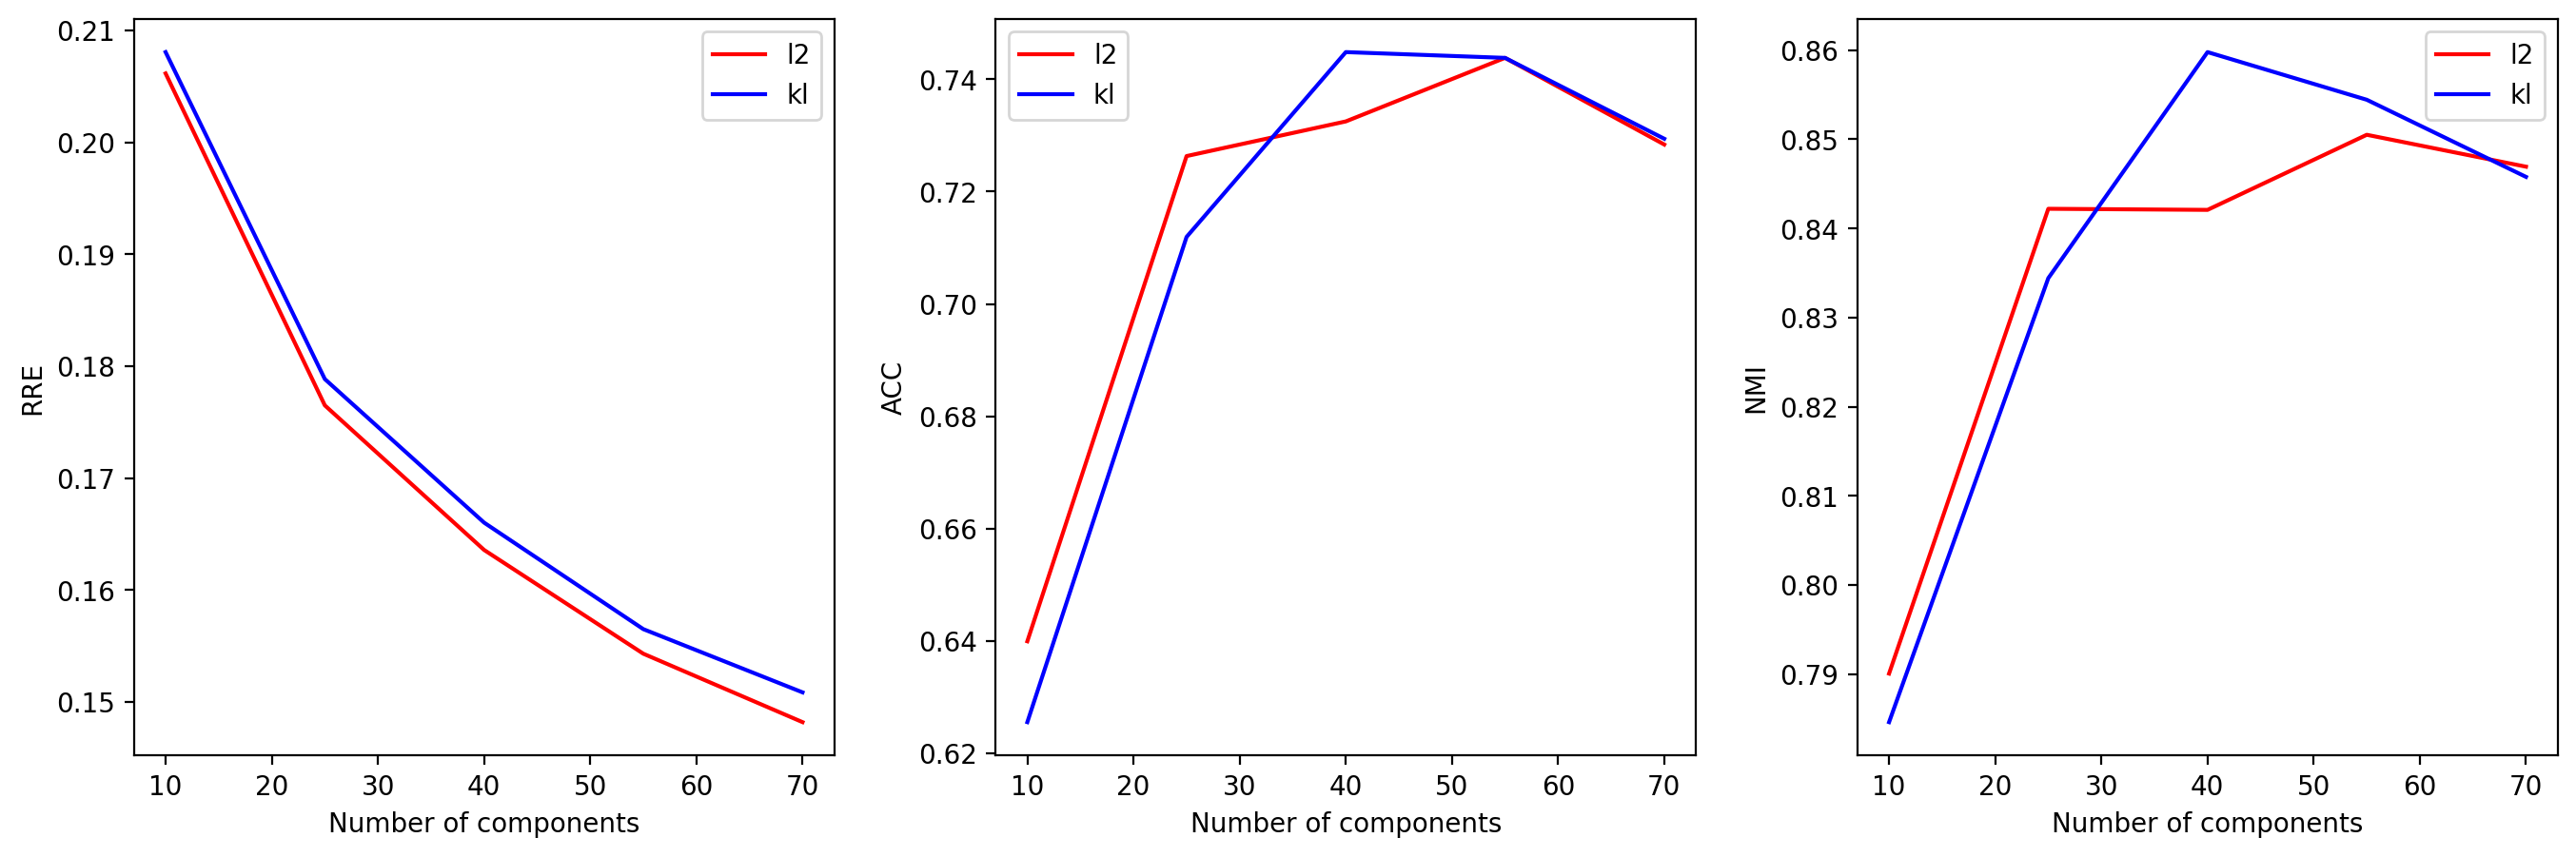

In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_components, [item[0] for item in overall_mean_rre], color="red", label=alg[0])
ax1.plot(n_components, [item[1] for item in overall_mean_rre], color="blue", label=alg[1])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Number of components")

# Plot ACC
ax2.plot(n_components, [item[0] for item in overall_mean_acc], color="red", label=alg[0])
ax2.plot(n_components, [item[1] for item in overall_mean_acc], color="blue", label=alg[1])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Number of components")

# Plot NMI
ax3.plot(n_components, [item[0] for item in overall_mean_nmi], color="red", label=alg[0])
ax3.plot(n_components, [item[1] for item in overall_mean_nmi], color="blue", label=alg[1])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Number of components")

**Displaying the Standard Deviation**

Text(0.5, 66.44444444444444, 'Number of components')

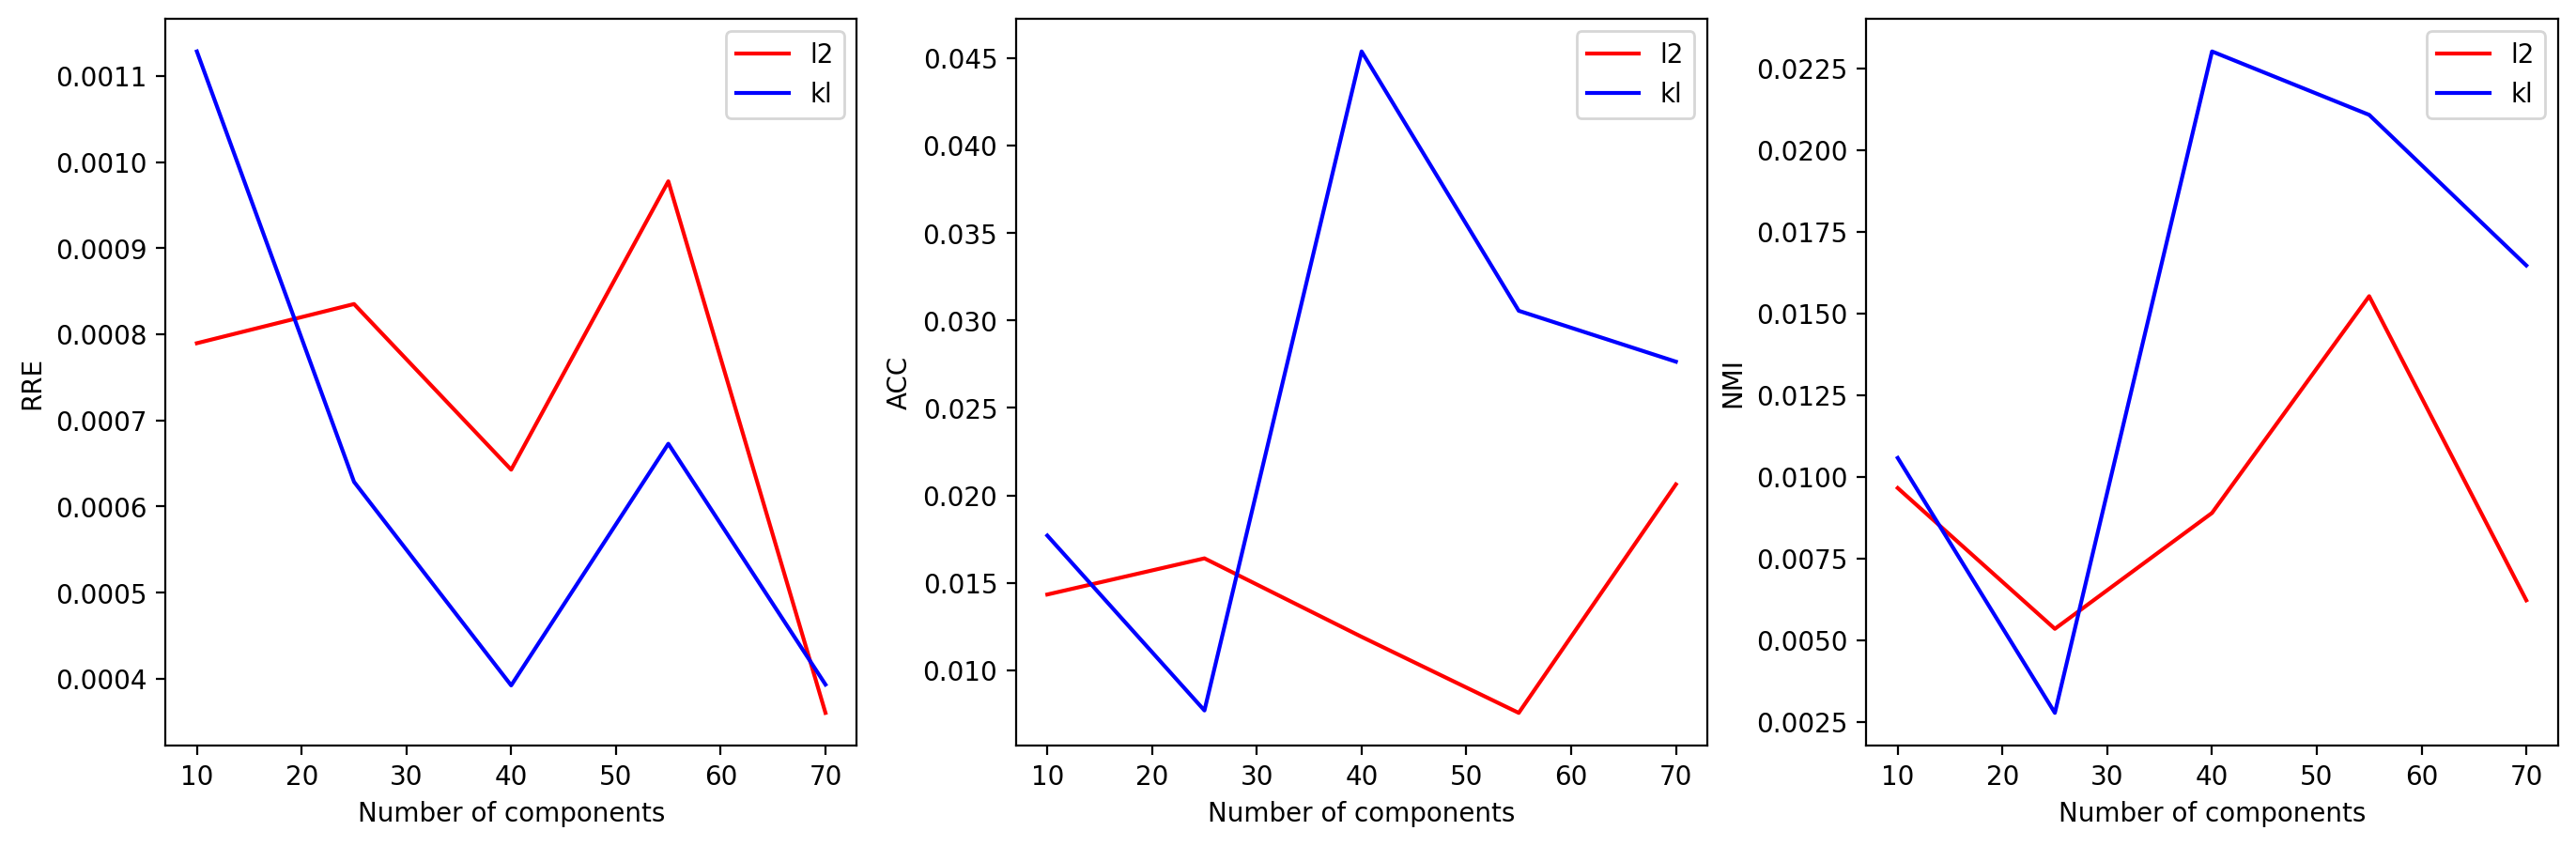

In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_components, [item[0] for item in overall_std_rre], color="red", label=alg[0])
ax1.plot(n_components, [item[1] for item in overall_std_rre], color="blue", label=alg[1])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Number of components")

# Plot ACC
ax2.plot(n_components, [item[0] for item in overall_std_acc], color="red", label=alg[0])
ax2.plot(n_components, [item[1] for item in overall_std_acc], color="blue", label=alg[1])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Number of components")

# Plot NMI
ax3.plot(n_components, [item[0] for item in overall_std_nmi], color="red", label=alg[0])
ax3.plot(n_components, [item[1] for item in overall_std_nmi], color="blue", label=alg[1])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Number of components")

Text(0.5, 66.44444444444456, 'Number of components')

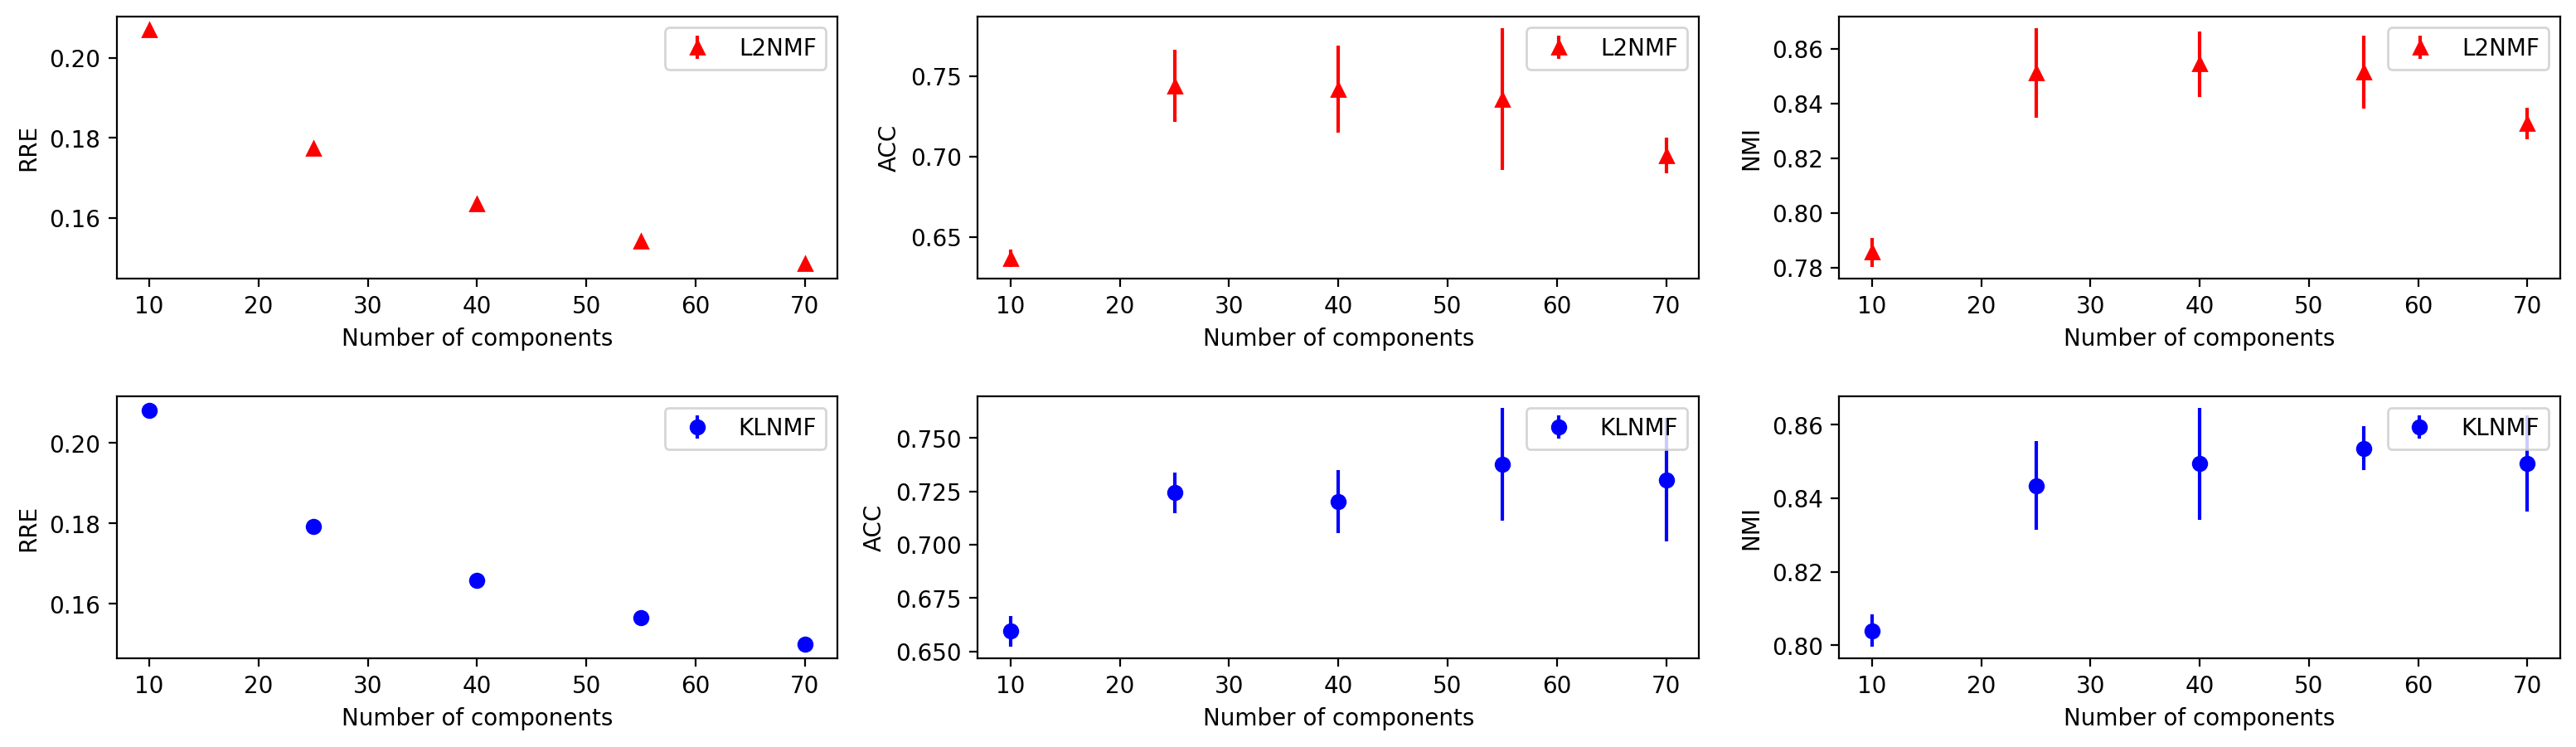

In [ ]:
# Display results
fig, ax = plt.subplots(2, 3, figsize=(16, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax[0, 0].errorbar(n_components, [item[0] for item in overall_mean_rre], [item[0] for item in overall_std_rre], 
             linestyle='None', color="red", fmt='^', label="L2NMF")
ax[1, 0].errorbar(n_components, [item[1] for item in overall_mean_rre], [item[1] for item in overall_std_rre], 
             linestyle='None', color="blue", fmt='o', label="KLNMF")
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_ylabel("RRE")
ax[1, 0].set_ylabel("RRE")
ax[0, 0].set_xlabel("Number of components")
ax[1, 0].set_xlabel("Number of components")

# Plot ACC
ax[0, 1].errorbar(n_components, [item[0] for item in overall_mean_acc], [item[0] for item in overall_std_acc], 
             linestyle='None', color="red", fmt='^', label="L2NMF")
ax[1, 1].errorbar(n_components, [item[1] for item in overall_mean_acc], [item[1] for item in overall_std_acc], 
             linestyle='None', color="blue", fmt='o', label="KLNMF")
ax[0, 1].legend()
ax[1, 1].legend()
ax[0, 1].set_ylabel("ACC")
ax[1, 1].set_ylabel("ACC")
ax[0, 1].set_xlabel("Number of components")
ax[1, 1].set_xlabel("Number of components")

# Plot NMI
ax[0, 2].errorbar(n_components, [item[0] for item in overall_mean_nmi], [item[0] for item in overall_std_nmi], 
             linestyle='None', color="red", fmt='^', label="L2NMF")
ax[1, 2].errorbar(n_components, [item[1] for item in overall_mean_nmi], [item[1] for item in overall_std_nmi], 
             linestyle='None', color="blue", fmt='o', label="KLNMF")
ax[0, 2].legend()
ax[1, 2].legend()
ax[0, 2].set_ylabel("NMI")
ax[1, 2].set_ylabel("NMI")
ax[0, 2].set_xlabel("Number of components")
ax[1, 2].set_xlabel("Number of components")

### 4.3.- Influence of Noise Scale

#### ORL
Gaussian noise scale experiment with different parameters

In [15]:
X, Y = load_data("data/orl_faces/Training", reduce=3)

# Experiment configuration
n_iters = 100
type_noise = "gaussian2d"
alg=["l2", "kl"]
params = {"mean": 0, "sigma": 0.001, "reg_param": 0.04}
n_sig = [0.01, 0.1, 0.5]
n_components = 60

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for sig in n_sig:
  print(f"Sigma value: {sig}")
  print("--------------------------------------------")

  params["sigma"] = sig
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Sigma value: 0.01
--------------------------------------------
Parameters: {'mean': 0, 'sigma': 0.01, 'reg_param': 0.04}
Running experiments for: l2
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 0.227 - Acc: 0.713 - NMI: 0.828
Iteration: 5 - Error: 0.204 - Acc: 0.664 - NMI: 0.807
Iteration: 10 - Error: 0.193 - Acc: 0.664 - NMI: 0.812
Iteration: 15 - Error: 0.185 - Acc: 0.704 - NMI: 0.842
Iteration: 20 - Error: 0.179 - Acc: 0.722 - NMI: 0.842
Iteration: 25 - Error: 0.174 - Acc: 0.676 - NMI: 0.826
Iteration: 30 - Error: 0.171 - Acc: 0.725 - NMI: 0.852
Iteration: 35 - Error: 0.167 - Acc: 0.738 - NMI: 0.862
Iteration: 40 - Error: 0.164 - Acc: 0.701 - NMI: 0.83
Iteration: 45 - Error: 0.162 - Acc: 0.707 - NMI: 0.839
Iteration: 50 - Error: 0.159 - Acc: 0.722 - NMI: 0.85
Iteration: 55 - Error: 0.158 - Acc: 0.71 - NMI: 0.832
Iteration: 60 - Error: 0.156 - Acc: 0.716 - NMI: 0.86
Iteration: 65 - Error: 0.154 - A

Text(0.5, 66.44444444444444, 'Sigma value')

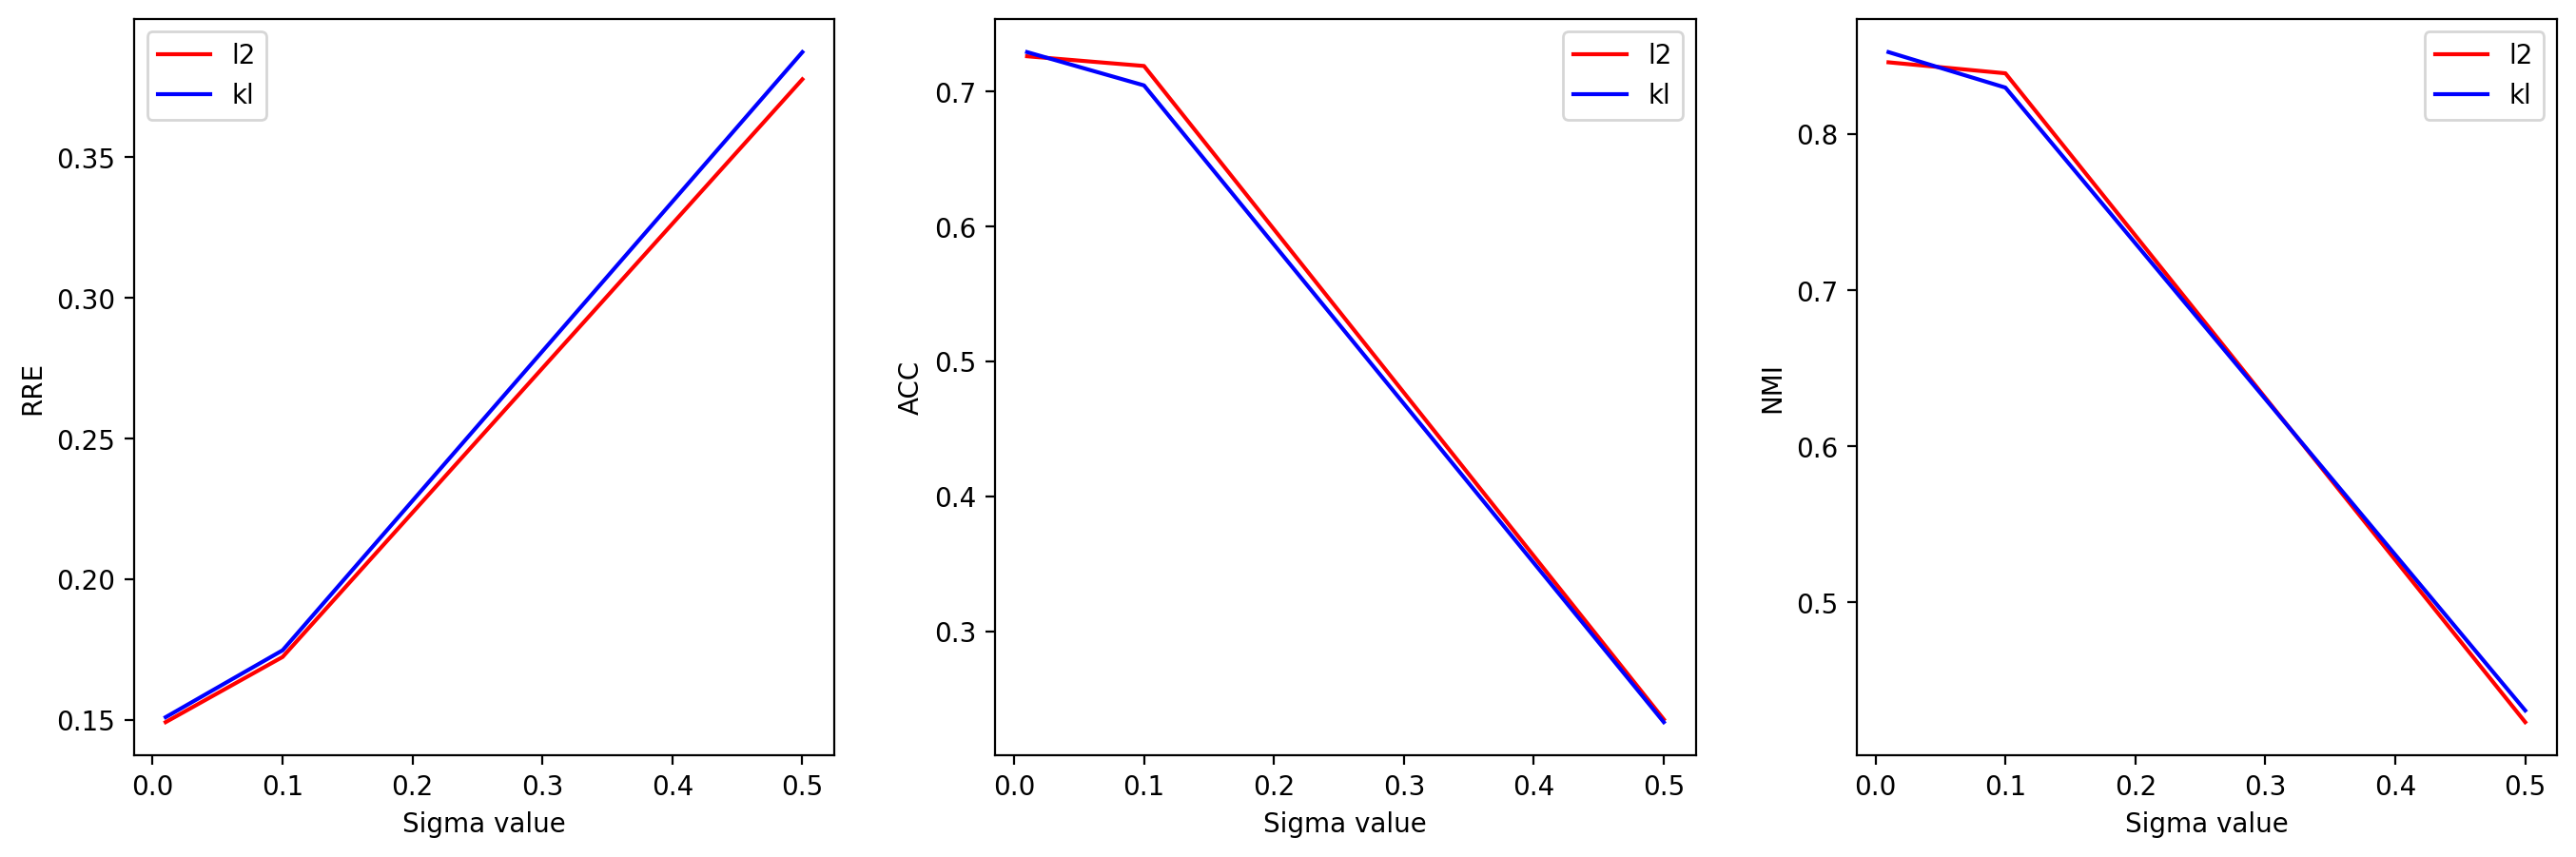

In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_sig, [item[0] for item in overall_mean_rre], color="red", label=alg[0])
ax1.plot(n_sig, [item[1] for item in overall_mean_rre], color="blue", label=alg[1])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Sigma value")

# Plot ACC
ax2.plot(n_sig, [item[0] for item in overall_mean_acc], color="red", label=alg[0])
ax2.plot(n_sig, [item[1] for item in overall_mean_acc], color="blue", label=alg[1])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Sigma value")

# Plot NMI
ax3.plot(n_sig, [item[0] for item in overall_mean_nmi], color="red", label=alg[0])
ax3.plot(n_sig, [item[1] for item in overall_mean_nmi], color="blue", label=alg[1])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Sigma value")

#### Yaleface

In [16]:
X, Y = load_data("data/yale_faces/Training", reduce=3)

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for sig in n_sig:
  print(f"Sigma value: {sig}")
  print("--------------------------------------------")

  params["sigma"] = sig
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_experiment=2, 
                                                           n_iters=n_iters,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Sigma value: 0.01
--------------------------------------------
Parameters: {'mean': 0, 'sigma': 0.01, 'reg_param': 0.04}
Running experiments for: l2
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 0.245 - Acc: 0.63 - NMI: 0.67
Iteration: 5 - Error: 0.209 - Acc: 0.674 - NMI: 0.682
Iteration: 10 - Error: 0.189 - Acc: 0.704 - NMI: 0.695
Iteration: 15 - Error: 0.174 - Acc: 0.615 - NMI: 0.653
Iteration: 20 - Error: 0.163 - Acc: 0.63 - NMI: 0.661
Iteration: 25 - Error: 0.154 - Acc: 0.667 - NMI: 0.681
Iteration: 30 - Error: 0.148 - Acc: 0.607 - NMI: 0.672
Iteration: 35 - Error: 0.143 - Acc: 0.659 - NMI: 0.708
Iteration: 40 - Error: 0.139 - Acc: 0.667 - NMI: 0.72
Iteration: 45 - Error: 0.136 - Acc: 0.696 - NMI: 0.713
Iteration: 50 - Error: 0.134 - Acc: 0.644 - NMI: 0.667
Iteration: 55 - Error: 0.132 - Acc: 0.659 - NMI: 0.696
Iteration: 60 - Error: 0.13 - Acc: 0.674 - NMI: 0.699
Iteration: 65 - Error: 0.129 - Ac

Text(0.5, 66.44444444444444, 'Sigma value')

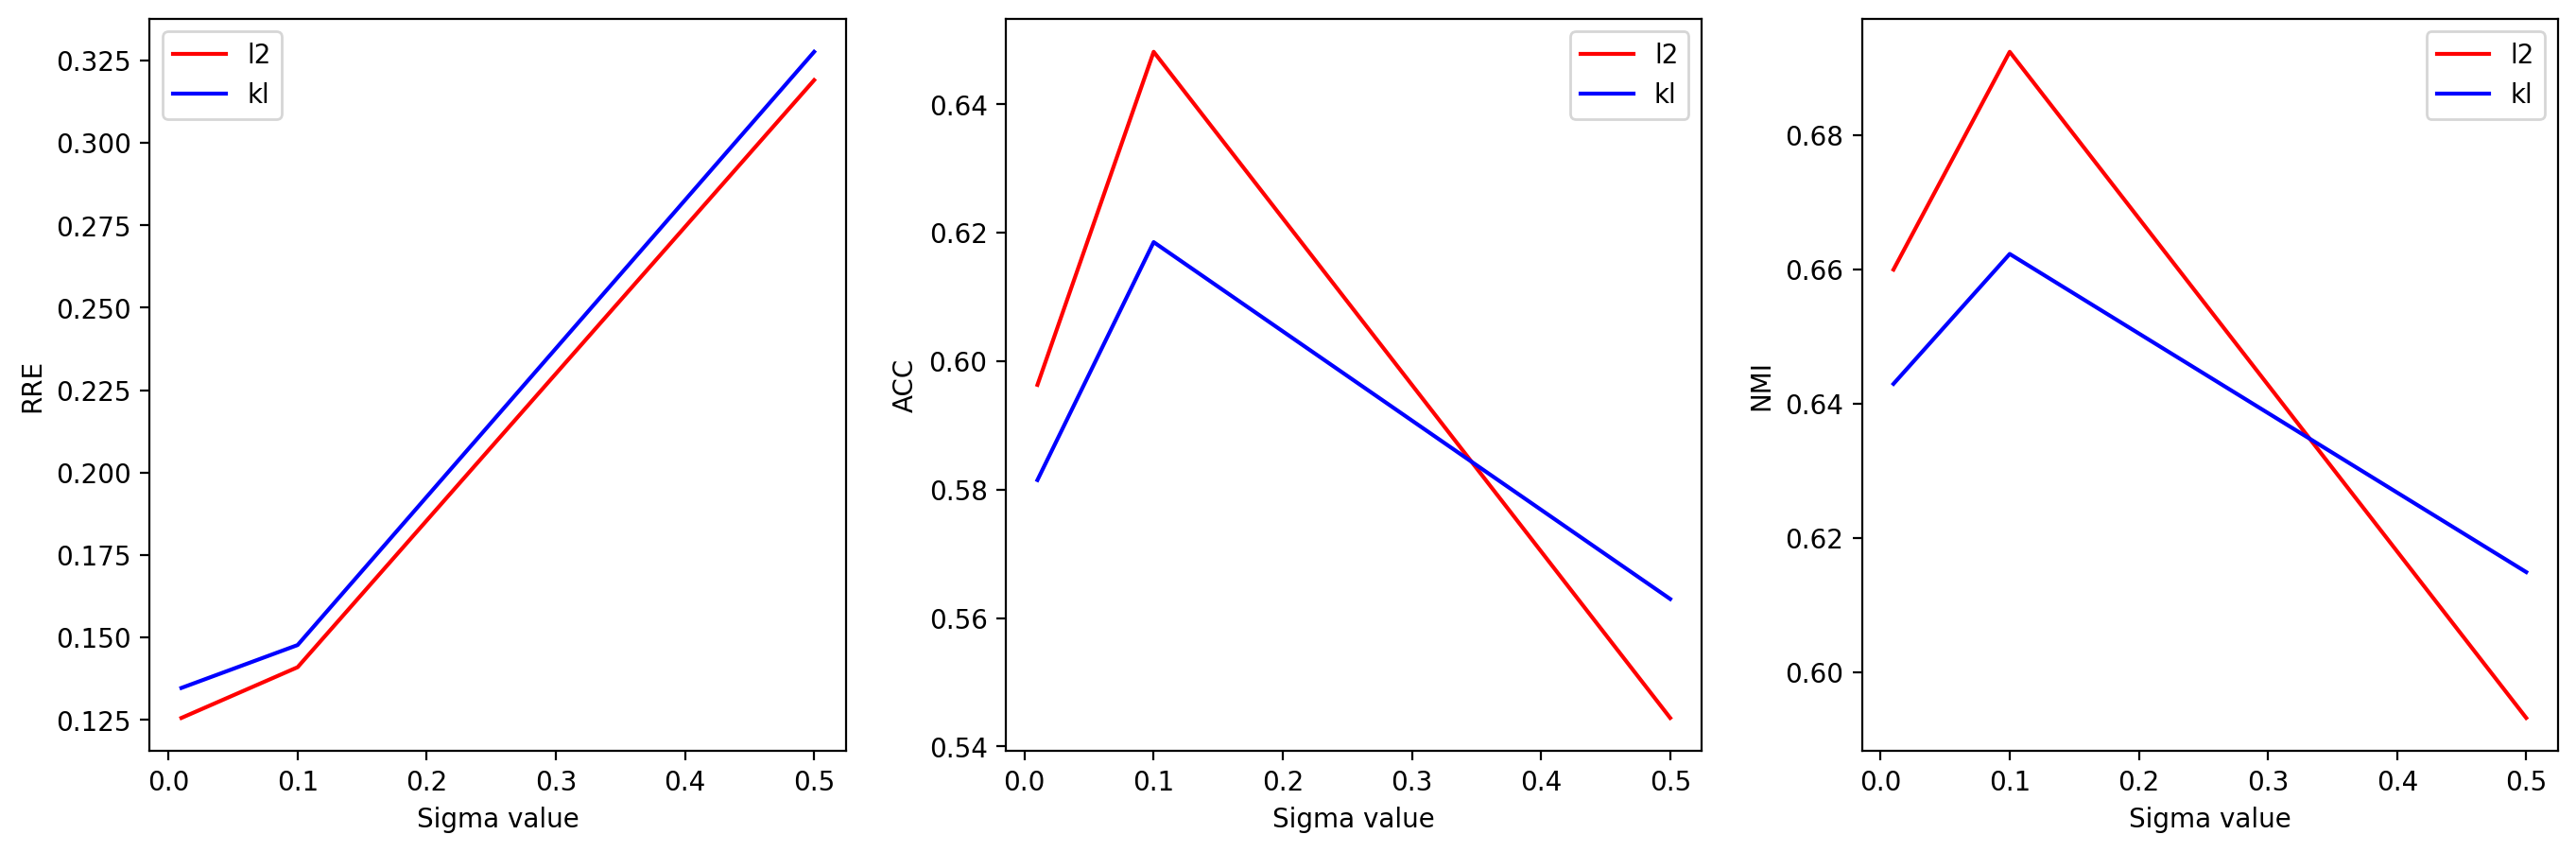

In [ ]:
# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5), dpi=200)
fig.tight_layout(pad=3.0)

# Plot RRE
ax1.plot(n_sig, [item[0] for item in overall_mean_rre], color="red", label=alg[0])
ax1.plot(n_sig, [item[1] for item in overall_mean_rre], color="blue", label=alg[1])
ax1.legend()
ax1.set_ylabel("RRE")
ax1.set_xlabel("Sigma value")

# Plot ACC
ax2.plot(n_sig, [item[0] for item in overall_mean_acc], color="red", label=alg[0])
ax2.plot(n_sig, [item[1] for item in overall_mean_acc], color="blue", label=alg[1])
ax2.legend()
ax2.set_ylabel("ACC")
ax2.set_xlabel("Sigma value")

# Plot NMI
ax3.plot(n_sig, [item[0] for item in overall_mean_nmi], color="red", label=alg[0])
ax3.plot(n_sig, [item[1] for item in overall_mean_nmi], color="blue", label=alg[1])
ax3.legend()
ax3.set_ylabel("NMI")
ax3.set_xlabel("Sigma value")

### 4.4.- Performance Comparison

#### Prepare parameters

In [ ]:
n_components = 60
n_iters = 300
n_experiments = np.arange(3)
n_repeat = 3
alg=["l2", "kl"]
params = {"p": 0, "s_vs_p": 0, "loc": 0, "scale": 0, "reg_param": 0.04}

####Salt & Pepper Noise Experiments

In [ ]:
type_noise = "salt_pepper"
p=[0.125, 0.188, 0.25]
svp=[0.167, 0.25, 0.333]

#####ORL

In [17]:
X, Y = load_data("data/orl_faces/Training", reduce=3)

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Component: {n_exp}")
  print("--------------------------------------------")
  params["p"]=p[n_exp]
  params["s_vs_p"]=svp[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Component: 0
--------------------------------------------
Parameters: {'p': 0.125, 's_vs_p': 0.167, 'loc': 0, 'scale': 0, 'reg_param': 0.04}
Running experiments for: l2
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 0.255 - Acc: 0.515 - NMI: 0.687
Iteration: 5 - Error: 0.241 - Acc: 0.512 - NMI: 0.667
Iteration: 10 - Error: 0.236 - Acc: 0.519 - NMI: 0.682
Iteration: 15 - Error: 0.235 - Acc: 0.531 - NMI: 0.689
Iteration: 20 - Error: 0.235 - Acc: 0.506 - NMI: 0.675
Iteration: 25 - Error: 0.235 - Acc: 0.525 - NMI: 0.682
Iteration: 30 - Error: 0.235 - Acc: 0.568 - NMI: 0.727
Iteration: 35 - Error: 0.235 - Acc: 0.5 - NMI: 0.695
Iteration: 40 - Error: 0.235 - Acc: 0.528 - NMI: 0.691
Iteration: 45 - Error: 0.235 - Acc: 0.534 - NMI: 0.697
Iteration: 50 - Error: 0.235 - Acc: 0.562 - NMI: 0.728
Iteration: 55 - Error: 0.235 - Acc: 0.562 - NMI: 0.715
Iteration: 60 - Error: 0.235 - Acc: 0.556 - NMI: 0.714
Ite

##### Yaleface

In [18]:
X, Y = load_data("data/yale_faces/Training", reduce=3)
n_iters = 100
n_repeat = 2

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Component: {n_exp+1}")
  print("--------------------------------------------")
  params["p"]=p[n_exp]
  params["s_vs_p"]=svp[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_experiment=n_repeat,
                                                           n_components=n_components,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Component: 1
--------------------------------------------
Parameters: {'p': 0.125, 's_vs_p': 0.167, 'loc': 0, 'scale': 0, 'reg_param': 0.04}
Running experiments for: l2
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 0.271 - Acc: 0.526 - NMI: 0.549
Iteration: 5 - Error: 0.249 - Acc: 0.607 - NMI: 0.659
Iteration: 10 - Error: 0.242 - Acc: 0.563 - NMI: 0.595
Iteration: 15 - Error: 0.239 - Acc: 0.6 - NMI: 0.64
Iteration: 20 - Error: 0.237 - Acc: 0.607 - NMI: 0.658
Iteration: 25 - Error: 0.236 - Acc: 0.585 - NMI: 0.64
Iteration: 30 - Error: 0.236 - Acc: 0.63 - NMI: 0.669
Iteration: 35 - Error: 0.235 - Acc: 0.556 - NMI: 0.619
Iteration: 40 - Error: 0.235 - Acc: 0.607 - NMI: 0.636
Iteration: 45 - Error: 0.235 - Acc: 0.578 - NMI: 0.639
Iteration: 50 - Error: 0.236 - Acc: 0.578 - NMI: 0.62
Iteration: 55 - Error: 0.236 - Acc: 0.57 - NMI: 0.645
Iteration: 60 - Error: 0.236 - Acc: 0.578 - NMI: 0.639
Iteratio

#### Gaussian Noise Experiments

Already done in 4.3.- Influence of Noise Scale

####Laplacian Noise Experiments

In [ ]:
type_noise = "laplace"
scales = [0.06, 0.09, 0.12]
n_iters = 200
n_repeat = 3

#####ORL

In [19]:
X, Y = load_data("data/orl_faces/Training", reduce=3)
n_iters = 300
n_repeat = 3

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Experiment: {n_exp}")
  print("--------------------------------------------")
  params["scale"]=scales[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_components=n_comp,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Experiment: 0
--------------------------------------------
Parameters: {'p': 0.25, 's_vs_p': 0.333, 'loc': 0, 'scale': 0.06, 'reg_param': 0.04}
Running experiments for: l2
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 0.231 - Acc: 0.636 - NMI: 0.78
Iteration: 5 - Error: 0.21 - Acc: 0.63 - NMI: 0.769
Iteration: 10 - Error: 0.2 - Acc: 0.66 - NMI: 0.793
Iteration: 15 - Error: 0.193 - Acc: 0.67 - NMI: 0.797
Iteration: 20 - Error: 0.188 - Acc: 0.645 - NMI: 0.798
Iteration: 25 - Error: 0.184 - Acc: 0.664 - NMI: 0.802
Iteration: 30 - Error: 0.181 - Acc: 0.698 - NMI: 0.819
Iteration: 35 - Error: 0.179 - Acc: 0.667 - NMI: 0.797
Iteration: 40 - Error: 0.176 - Acc: 0.707 - NMI: 0.821
Iteration: 45 - Error: 0.175 - Acc: 0.657 - NMI: 0.794
Iteration: 50 - Error: 0.173 - Acc: 0.694 - NMI: 0.814
Iteration: 55 - Error: 0.171 - Acc: 0.67 - NMI: 0.825
Iteration: 60 - Error: 0.17 - Acc: 0.704 - NMI: 0.821
Iterati

#####Yaleface

In [20]:
X, Y = load_data("data/yale_faces/Training", reduce=3)
n_iters = 100
n_repeat = 2

In [ ]:
overall_mean_rre = []
overall_mean_acc = []
overall_mean_nmi = []
overall_std_rre = []
overall_std_acc = []
overall_std_nmi = []

for n_exp in n_experiments:
  print(f"Number Experiment: {n_exp+1}")
  print("--------------------------------------------")
  params["scale"]=scales[n_exp]
  mean_result_metrics, std_result_metrics = run_experiment(alg=alg, 
                                                           n_iters=n_iters,
                                                           n_experiment=n_repeat,
                                                           n_components=n_comp,
                                                           type_noise=type_noise,
                                                           kwarg=params)
  # Extract mean values
  rre_mean_vle = [item[0] for item in mean_result_metrics]
  acc_mean_vle = [item[1] for item in mean_result_metrics]
  nmi_mean_vle = [item[2] for item in mean_result_metrics]

  # Extract std values
  rre_std_vle = [item[0] for item in std_result_metrics]
  acc_std_vle = [item[1] for item in std_result_metrics]
  nmi_std_vle = [item[2] for item in std_result_metrics]

  # Append results
  overall_mean_rre.append(rre_mean_vle)
  overall_mean_acc.append(acc_mean_vle)
  overall_mean_nmi.append(nmi_mean_vle)

  overall_std_rre.append(rre_std_vle)
  overall_std_acc.append(acc_std_vle)
  overall_std_nmi.append(nmi_std_vle)

Number Experiment: 1
--------------------------------------------
Parameters: {'p': 0.25, 's_vs_p': 0.333, 'loc': 0, 'scale': 0.06, 'reg_param': 0.04}
Running experiments for: l2
--------------------------------------------

Experiment number: 1
-.-.-.--.-.-.--.-.-.--.-.-.--.-.-.--.-.-.-
Iteration: 0 - Error: 0.25 - Acc: 0.615 - NMI: 0.656
Iteration: 5 - Error: 0.213 - Acc: 0.57 - NMI: 0.628
Iteration: 10 - Error: 0.193 - Acc: 0.63 - NMI: 0.663
Iteration: 15 - Error: 0.18 - Acc: 0.622 - NMI: 0.674
Iteration: 20 - Error: 0.171 - Acc: 0.541 - NMI: 0.666
Iteration: 25 - Error: 0.164 - Acc: 0.57 - NMI: 0.649
Iteration: 30 - Error: 0.158 - Acc: 0.57 - NMI: 0.656
Iteration: 35 - Error: 0.154 - Acc: 0.6 - NMI: 0.705
Iteration: 40 - Error: 0.15 - Acc: 0.593 - NMI: 0.674
Iteration: 45 - Error: 0.148 - Acc: 0.593 - NMI: 0.659
Iteration: 50 - Error: 0.146 - Acc: 0.622 - NMI: 0.682
Iteration: 55 - Error: 0.144 - Acc: 0.644 - NMI: 0.713
Iteration: 60 - Error: 0.142 - Acc: 0.637 - NMI: 0.686
Iterati

## Appendix

This section contains some visualizations generated for the report.

### SVD-based initialization

Go back to the implementation of NMF and switch SVD-based initialization to standard randomization to compare

In [21]:
X, Y = load_data("data/yale_faces/Training", reduce=3)

In [ ]:
# Initialize algorithm
randL2 = L2NMF()

# Run it
W, H = randL2.fit(X=X, 
                 X_noisy=X, 
                 Y=Y, 
                 n_components=30, 
                 n_iter=40,
                 plot=False)

Iteration: 0 - Error: 0.309 - Acc: 0.238 - NMI: 0.255
Iteration: 5 - Error: 0.307 - Acc: 0.258 - NMI: 0.239
Iteration: 10 - Error: 0.305 - Acc: 0.291 - NMI: 0.32
Iteration: 15 - Error: 0.296 - Acc: 0.377 - NMI: 0.435
Iteration: 20 - Error: 0.267 - Acc: 0.444 - NMI: 0.523
Iteration: 25 - Error: 0.241 - Acc: 0.503 - NMI: 0.59
Iteration: 30 - Error: 0.227 - Acc: 0.543 - NMI: 0.614
Iteration: 35 - Error: 0.214 - Acc: 0.583 - NMI: 0.629


In [ ]:
# Initialize algorithm
svdL2 = L2NMF()

# Run it
W, H = svdL2.fit(X=X, 
                 X_noisy=X, 
                 Y=Y, 
                 n_components=30, 
                 n_iter=40,
                 plot=False)

Iteration: 0 - Error: 0.246 - Acc: 0.596 - NMI: 0.617
Iteration: 5 - Error: 0.213 - Acc: 0.609 - NMI: 0.628
Iteration: 10 - Error: 0.194 - Acc: 0.589 - NMI: 0.619
Iteration: 15 - Error: 0.182 - Acc: 0.656 - NMI: 0.671
Iteration: 20 - Error: 0.173 - Acc: 0.656 - NMI: 0.693
Iteration: 25 - Error: 0.167 - Acc: 0.662 - NMI: 0.705
Iteration: 30 - Error: 0.162 - Acc: 0.609 - NMI: 0.687
Iteration: 35 - Error: 0.159 - Acc: 0.623 - NMI: 0.695


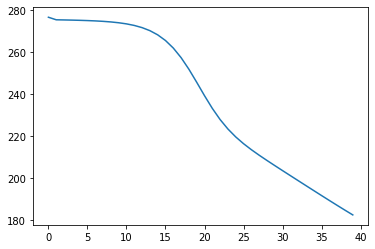

In [ ]:
plt.plot(randL2.loss)

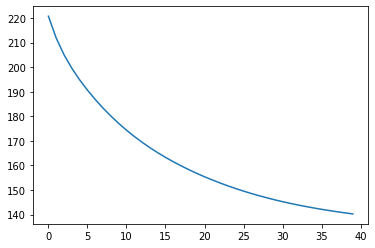

In [ ]:
plt.plot(svdL2.loss)

In [ ]:
# Initialize algorithm
randKL = KLNMF()

# Run it
W, H = randKL.fit(X=X, 
                 X_noisy=X, 
                 Y=Y, 
                 n_components=30, 
                 n_iter=40,
                 plot=False)

Iteration: 0 - Error: 0.309 - Acc: 0.272 - NMI: 0.262
Iteration: 5 - Error: 0.308 - Acc: 0.285 - NMI: 0.286
Iteration: 10 - Error: 0.303 - Acc: 0.351 - NMI: 0.391
Iteration: 15 - Error: 0.274 - Acc: 0.437 - NMI: 0.514
Iteration: 20 - Error: 0.237 - Acc: 0.523 - NMI: 0.585
Iteration: 25 - Error: 0.22 - Acc: 0.55 - NMI: 0.617
Iteration: 30 - Error: 0.207 - Acc: 0.596 - NMI: 0.648
Iteration: 35 - Error: 0.193 - Acc: 0.596 - NMI: 0.673


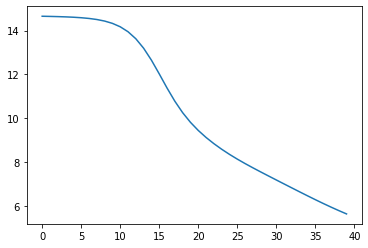

In [ ]:
plt.plot(randKL.loss)

In [ ]:
# Initialize algorithm
svdKL = KLNMF()

# Run it
W, H = svdKL.fit(X=X, 
                 X_noisy=X, 
                 Y=Y, 
                 n_components=30, 
                 n_iter=40,
                 plot=False)

Iteration: 0 - Error: 0.243 - Acc: 0.642 - NMI: 0.64
Iteration: 5 - Error: 0.207 - Acc: 0.636 - NMI: 0.651
Iteration: 10 - Error: 0.189 - Acc: 0.649 - NMI: 0.679
Iteration: 15 - Error: 0.177 - Acc: 0.636 - NMI: 0.684
Iteration: 20 - Error: 0.169 - Acc: 0.616 - NMI: 0.705
Iteration: 25 - Error: 0.164 - Acc: 0.662 - NMI: 0.692
Iteration: 30 - Error: 0.161 - Acc: 0.649 - NMI: 0.725
Iteration: 35 - Error: 0.159 - Acc: 0.656 - NMI: 0.709


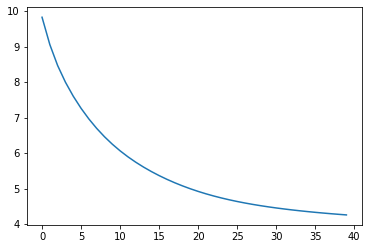

In [ ]:
plt.plot(svdKL.loss)

Text(0.5, 41.44444444444444, 'Iterations')

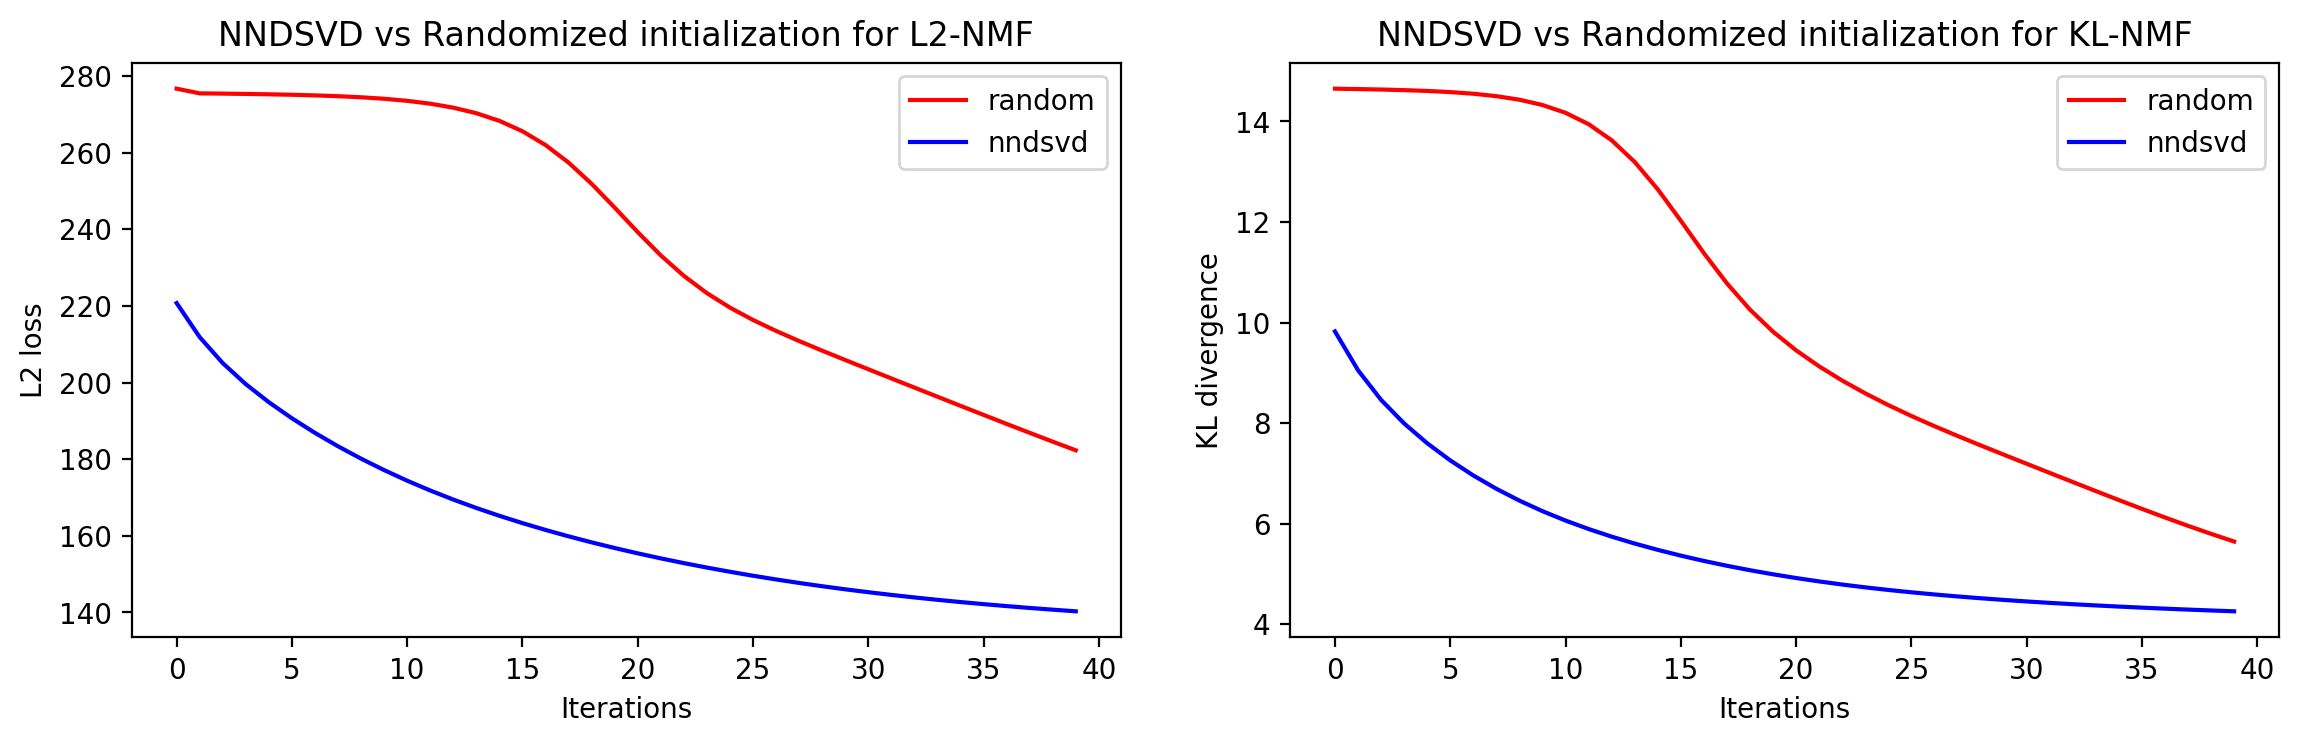

In [ ]:
# Display results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=200)
fig.tight_layout(pad=3.0)

# L2NMF
ax1.set_title("NNDSVD vs Randomized initialization for L2-NMF")
ax1.plot(randL2.loss, color="red", label="random")
ax1.plot(svdL2.loss, color="blue", label="nndsvd")
ax1.legend()
ax1.set_ylabel("L2 loss")
ax1.set_xlabel("Iterations")

# KLNMF
ax2.set_title("NNDSVD vs Randomized initialization for KL-NMF")
ax2.plot(randKL.loss, color="red", label="random")
ax2.plot(svdKL.loss, color="blue", label="nndsvd")
ax2.legend()
ax2.set_ylabel("KL divergence")
ax2.set_xlabel("Iterations")

### Add noise to data

In [ ]:
n_experiments = np.arange(6)
p = np.true_divide(n_experiments,16)
s_vs_p = np.true_divide(n_experiments,12)

In [22]:
X, Y = load_data("data/orl_faces/Training", reduce=3)

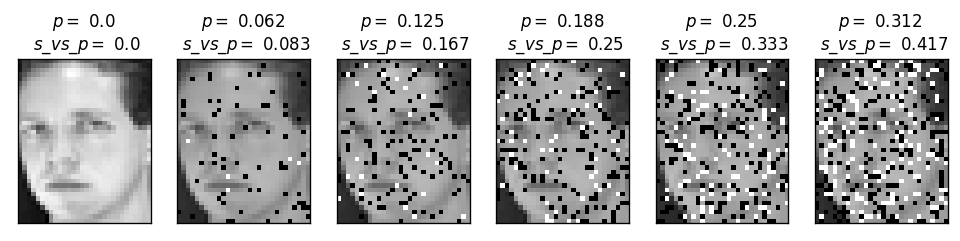

In [ ]:
# SALT AND PEPPER NOISE
# Plot n images
p_range = np.around(p,3) #[0, 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1]
s_vs_p_range = np.around(s_vs_p,3) #[0, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 1]

# Select random image
np.random.seed(42)
img_idx = np.random.randint(1, len(X))
img_size = [i//3 for i in (92, 112)]


plt.figure(figsize=(10, 6), dpi=120)
#plt.subplots_adjust(hspace=0.9)
for i, param in enumerate(zip(p_range, s_vs_p_range)):
    plt.subplot(2, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    p = param[0]
    s_vs_p = param[1]
    test_img_noise = salt_pepper_noise(X[:, :img_idx], p=p, s_vs_p=s_vs_p)

    test_img_noise = array2img(test_img_noise[:, 0], 
                        h=img_size[0],
                        w=img_size[1])

    # Set title
    plt.title(f'$p =$ {p} \n $s\_vs\_p =$ {s_vs_p}', fontsize=10)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

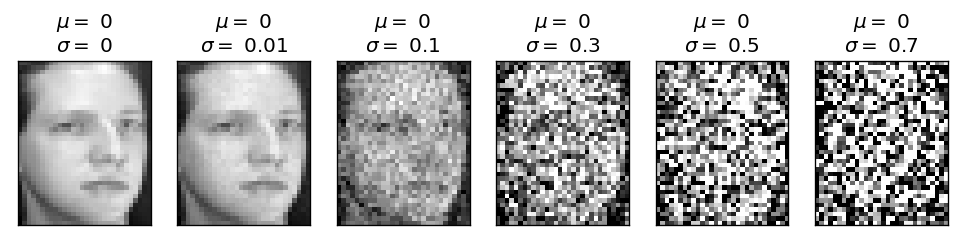

In [ ]:
# GAUSSIAN EXAMPLE
# Plot n images
sigma = [0, 0.01, 0.1, 0.3, 0.5, 0.7]

# Select random image
np.random.seed(42)
img_idx = np.random.randint(1, len(X))
img_size = [i//3 for i in (92, 112)] # ORL #92, 112

plt.figure(figsize=(10,6), dpi=120)
#plt.subplots_adjust(hspace=0.9)
for i, s in enumerate(sigma):
    plt.subplot(2, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    test_img_noise = gaussian_noise_2d(X, mean=0, sigma=s)


    test_img_noise = array2img(test_img_noise[:, 1], 
                        h=img_size[0],
                        w=img_size[1])

    # Set title
    plt.title(f'$\mu =$ 0\n$\sigma =$ {s}', fontsize=12)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

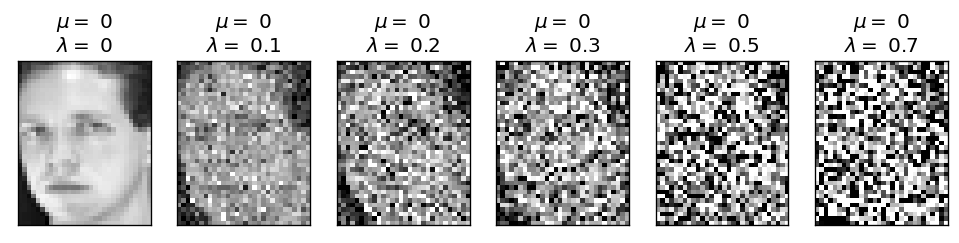

In [ ]:
# LAPLACE EXAMPLE
# Plot n images
sigma = [0, 0.1, 0.2, 0.3, 0.5, 0.7]

# Select random image
np.random.seed(42)
img_idx = np.random.randint(1, len(X))
img_size = [i//3 for i in (92, 112)] # ORL

plt.figure(figsize=(10,10), dpi=120)
#plt.subplots_adjust(hspace=0.9)
for i, s in enumerate(sigma):
    plt.subplot(2, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    test_img_noise = laplace_noise(X, loc=0, scale=s)


    test_img_noise = array2img(test_img_noise[:, 0], 
                        h=img_size[0],
                        w=img_size[1])

    # Set title
    plt.title(f'$\mu =$ 0\n$\lambda =$ {s}', fontsize=12)

    # Get label for this image
    plt.imshow(test_img_noise, cmap=plt.cm.gray)
plt.show()

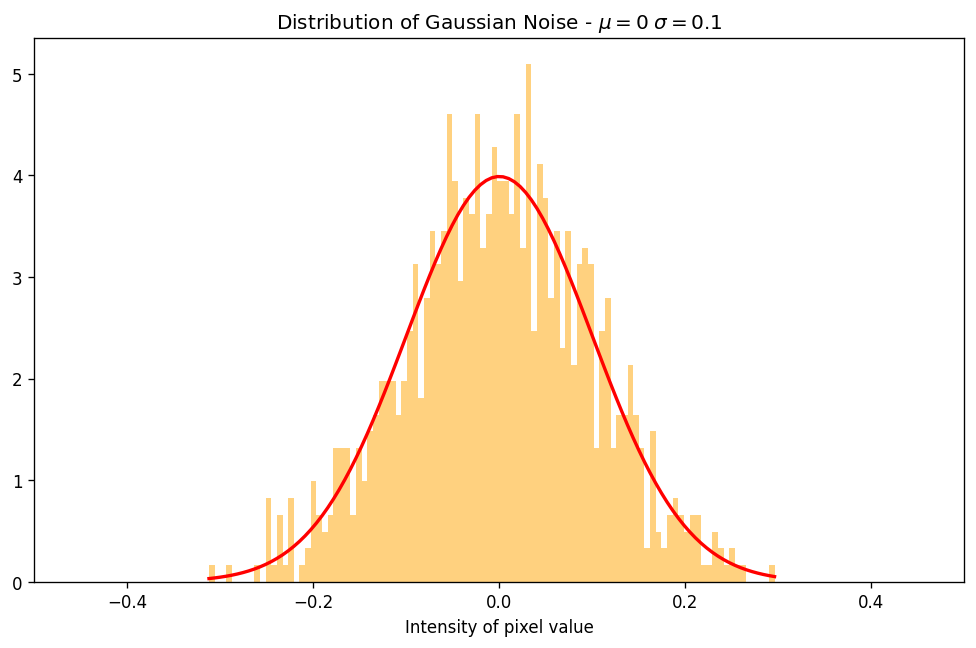

In [ ]:
# GAUSSIAN NOISE
import matplotlib.pyplot as plt
mu = 0
sigma = 0.1
s = np.random.normal(mu, sigma, 1000)

plt.figure(figsize=(10, 6), dpi=120)
count, bins, ignored = plt.hist(s, 100, density=True, color="orange", alpha=0.5)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.xlim((-0.5, 0.5))
plt.title("Distribution of Gaussian Noise - $\mu = 0 \; \sigma = 0.1$")
plt.xlabel("Intensity of pixel value")
plt.show()

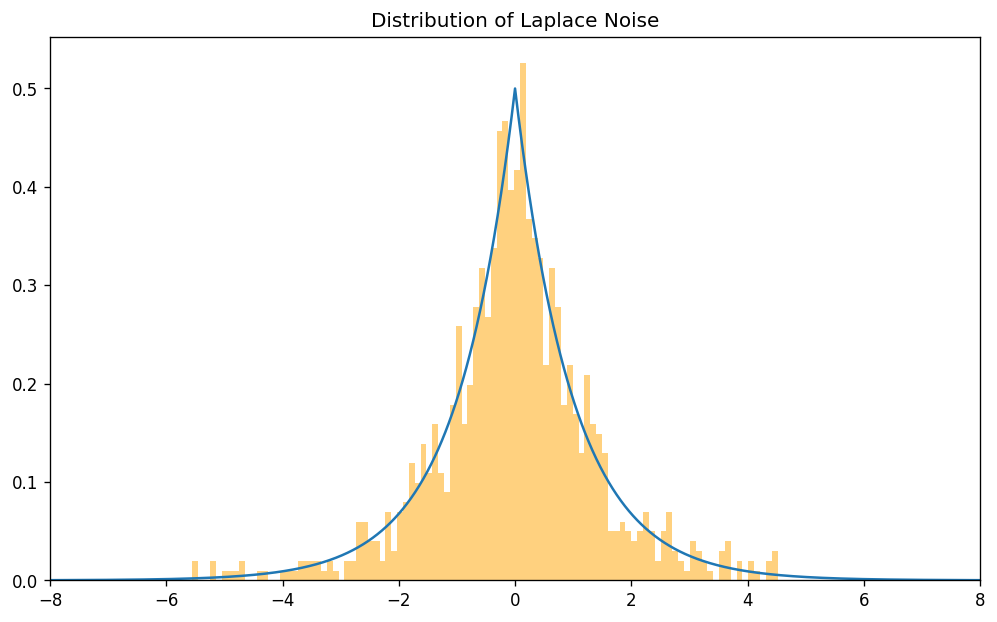

In [ ]:
# LAPLACE NOISE
import matplotlib.pyplot as plt
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)

plt.figure(figsize=(10, 6), dpi=120)
count, bins, ignored = plt.hist(s, 100, density=True, color="orange", alpha=0.5)

x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)
plt.xlim((-8, 8))
plt.title("Distribution of Laplace Noise")
plt.show()

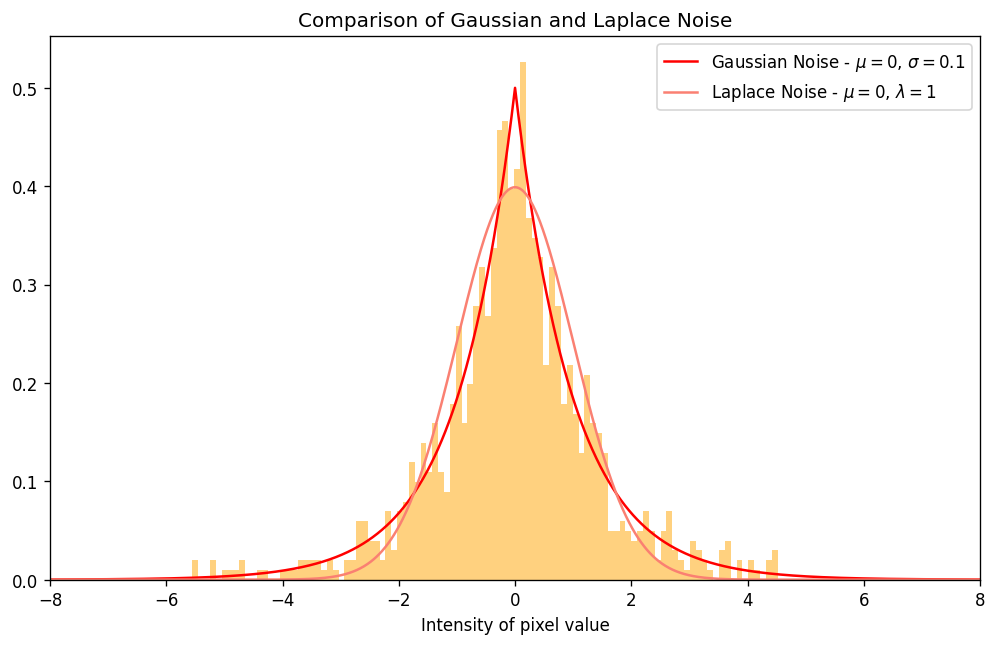

In [ ]:
# COMBINE BOTH
import matplotlib.pyplot as plt
mu = 0
sigma = 0.1
s_gauss = np.random.normal(mu, sigma, 1000)
loc, scale = 0., 1.
s_laplace = np.random.laplace(loc, scale, 1000)

plt.figure(figsize=(10, 6), dpi=120)
count, bins, ignored = plt.hist(s, 100, density=True, color="orange", alpha=0.5)

# Laplace
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf, color="r", label="Gaussian Noise - $\mu=0$, $\sigma=0.1$")

# Gaussian
g = (1/(scale * np.sqrt(2 * np.pi)) *
     np.exp(-(x - loc)**2 / (2 * scale**2)))
plt.plot(x, g, color="salmon", label="Laplace Noise - $\mu=0$, $\lambda=1$")

plt.xlim((-8, 8))
plt.title("Comparison of Gaussian and Laplace Noise")
plt.xlabel("Intensity of pixel value")
plt.legend()
plt.show()